In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, GRU
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953   
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424   
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722   
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717   
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164   
...          ...      ...              ...       ...        ...       ...   
1098200       19  Sitting  131623331483000  9.000000  -1.570000  1.690000   
1098201       19  Sitting  131623371431000  9.040000  -1.460000  1.730000   
1098202       19  Sitting  131623411592000  9.080000  -1.380000  1.690000   
1098203       19  Sitting  131623491487000  9.000000  -1.460000  1.730000   
1098204       19  Sitting  131623531465000  8.880000  -1.330000  1.610000   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

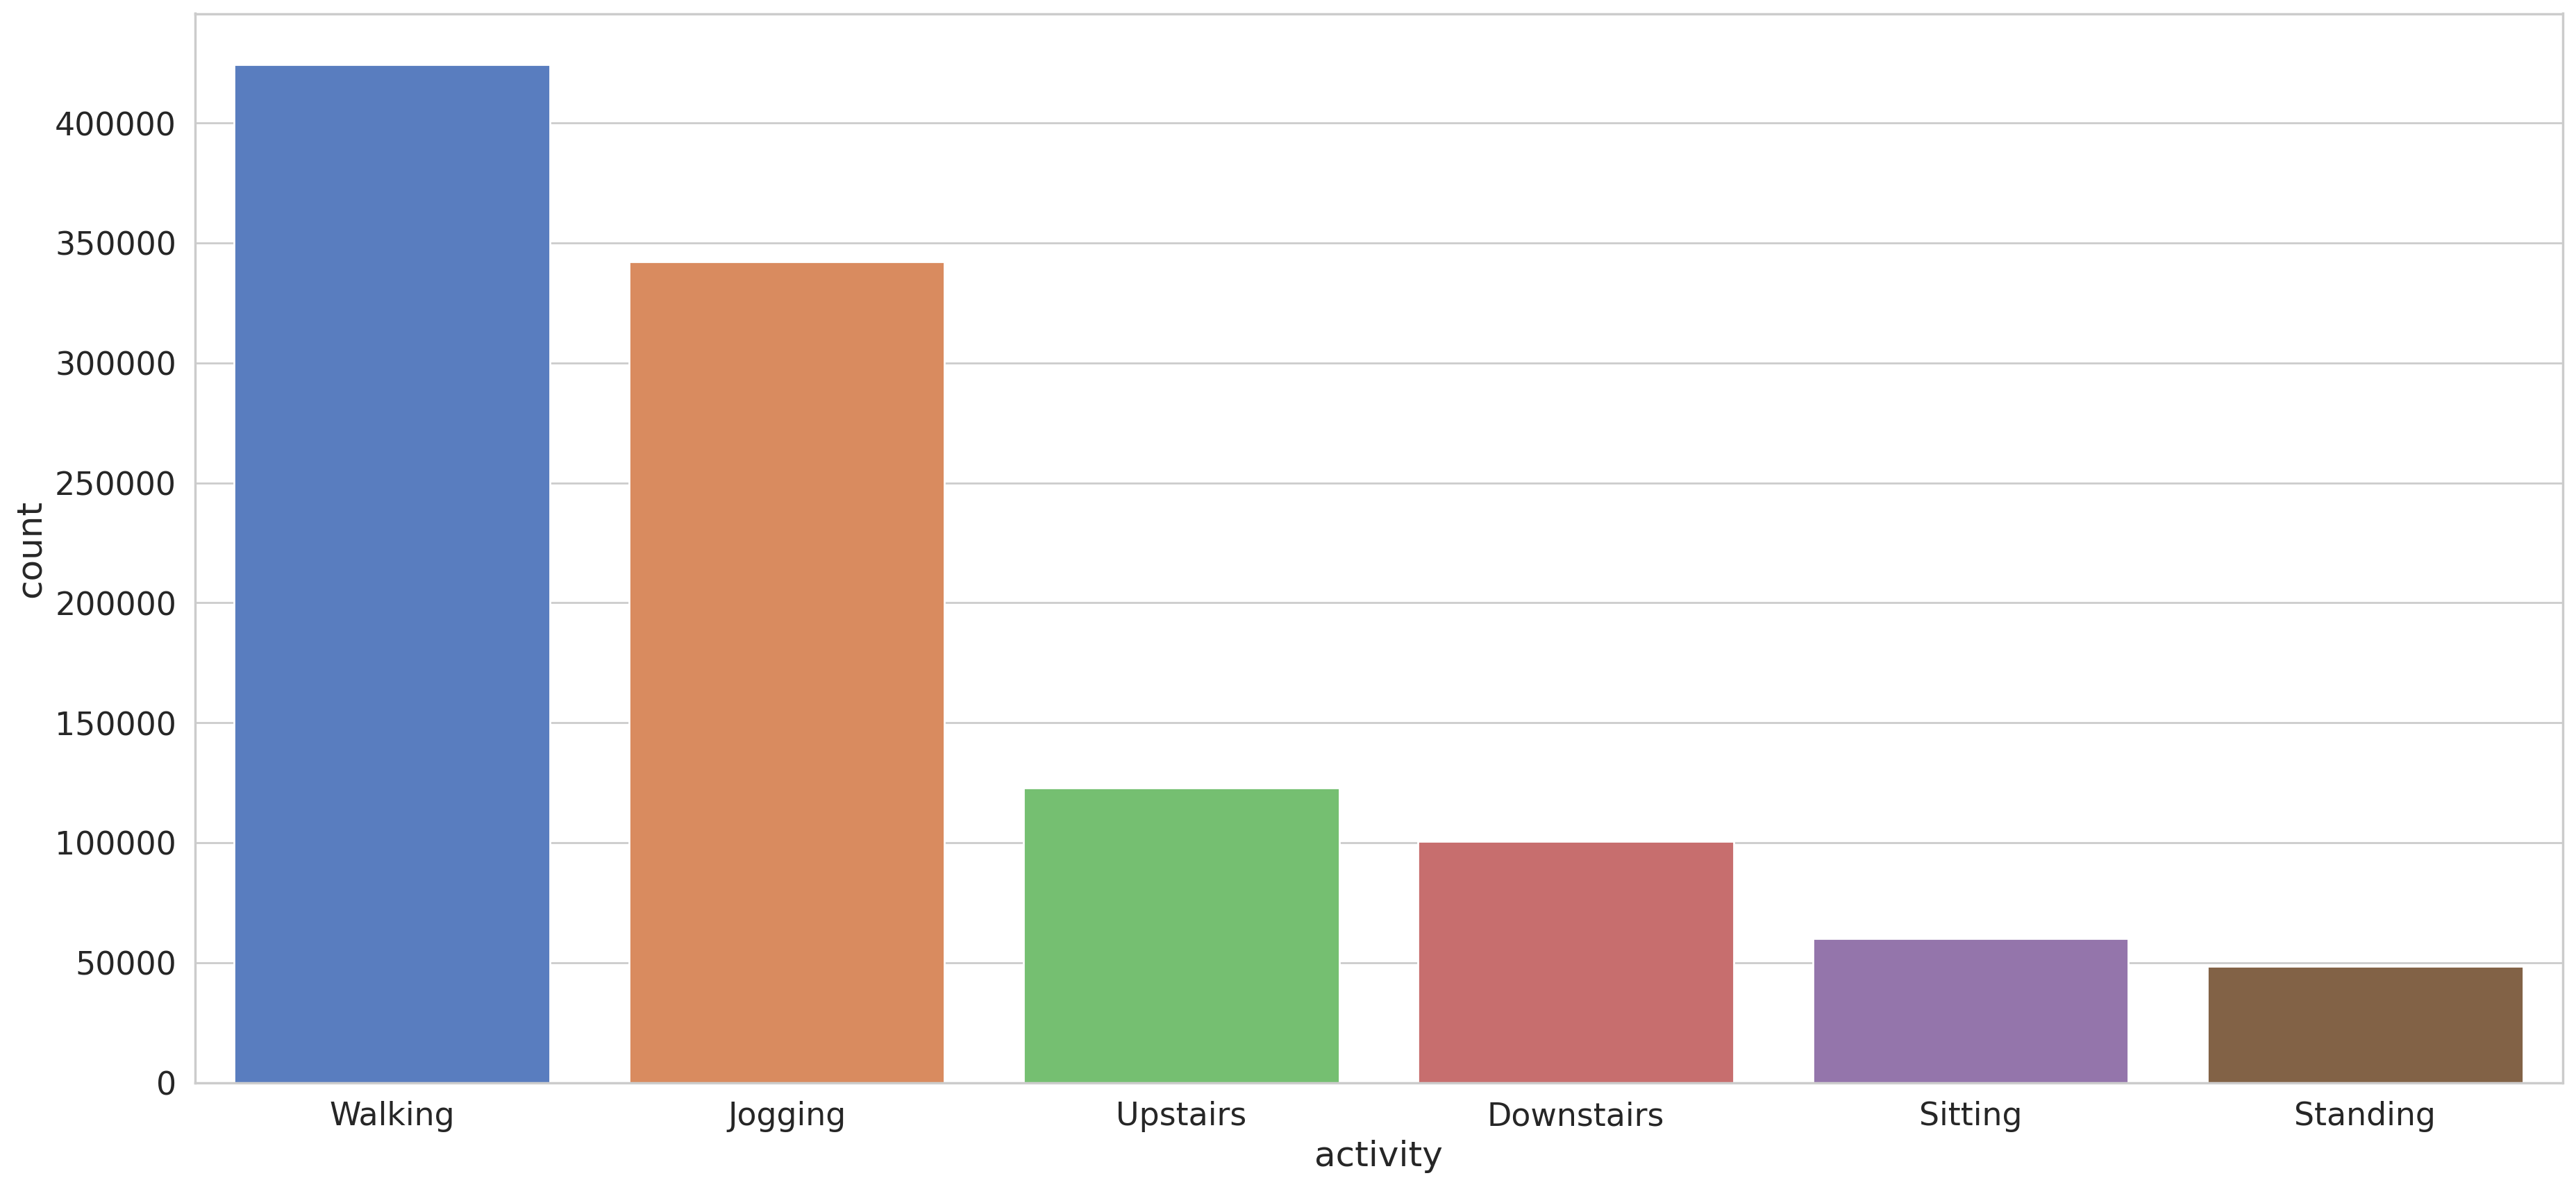

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

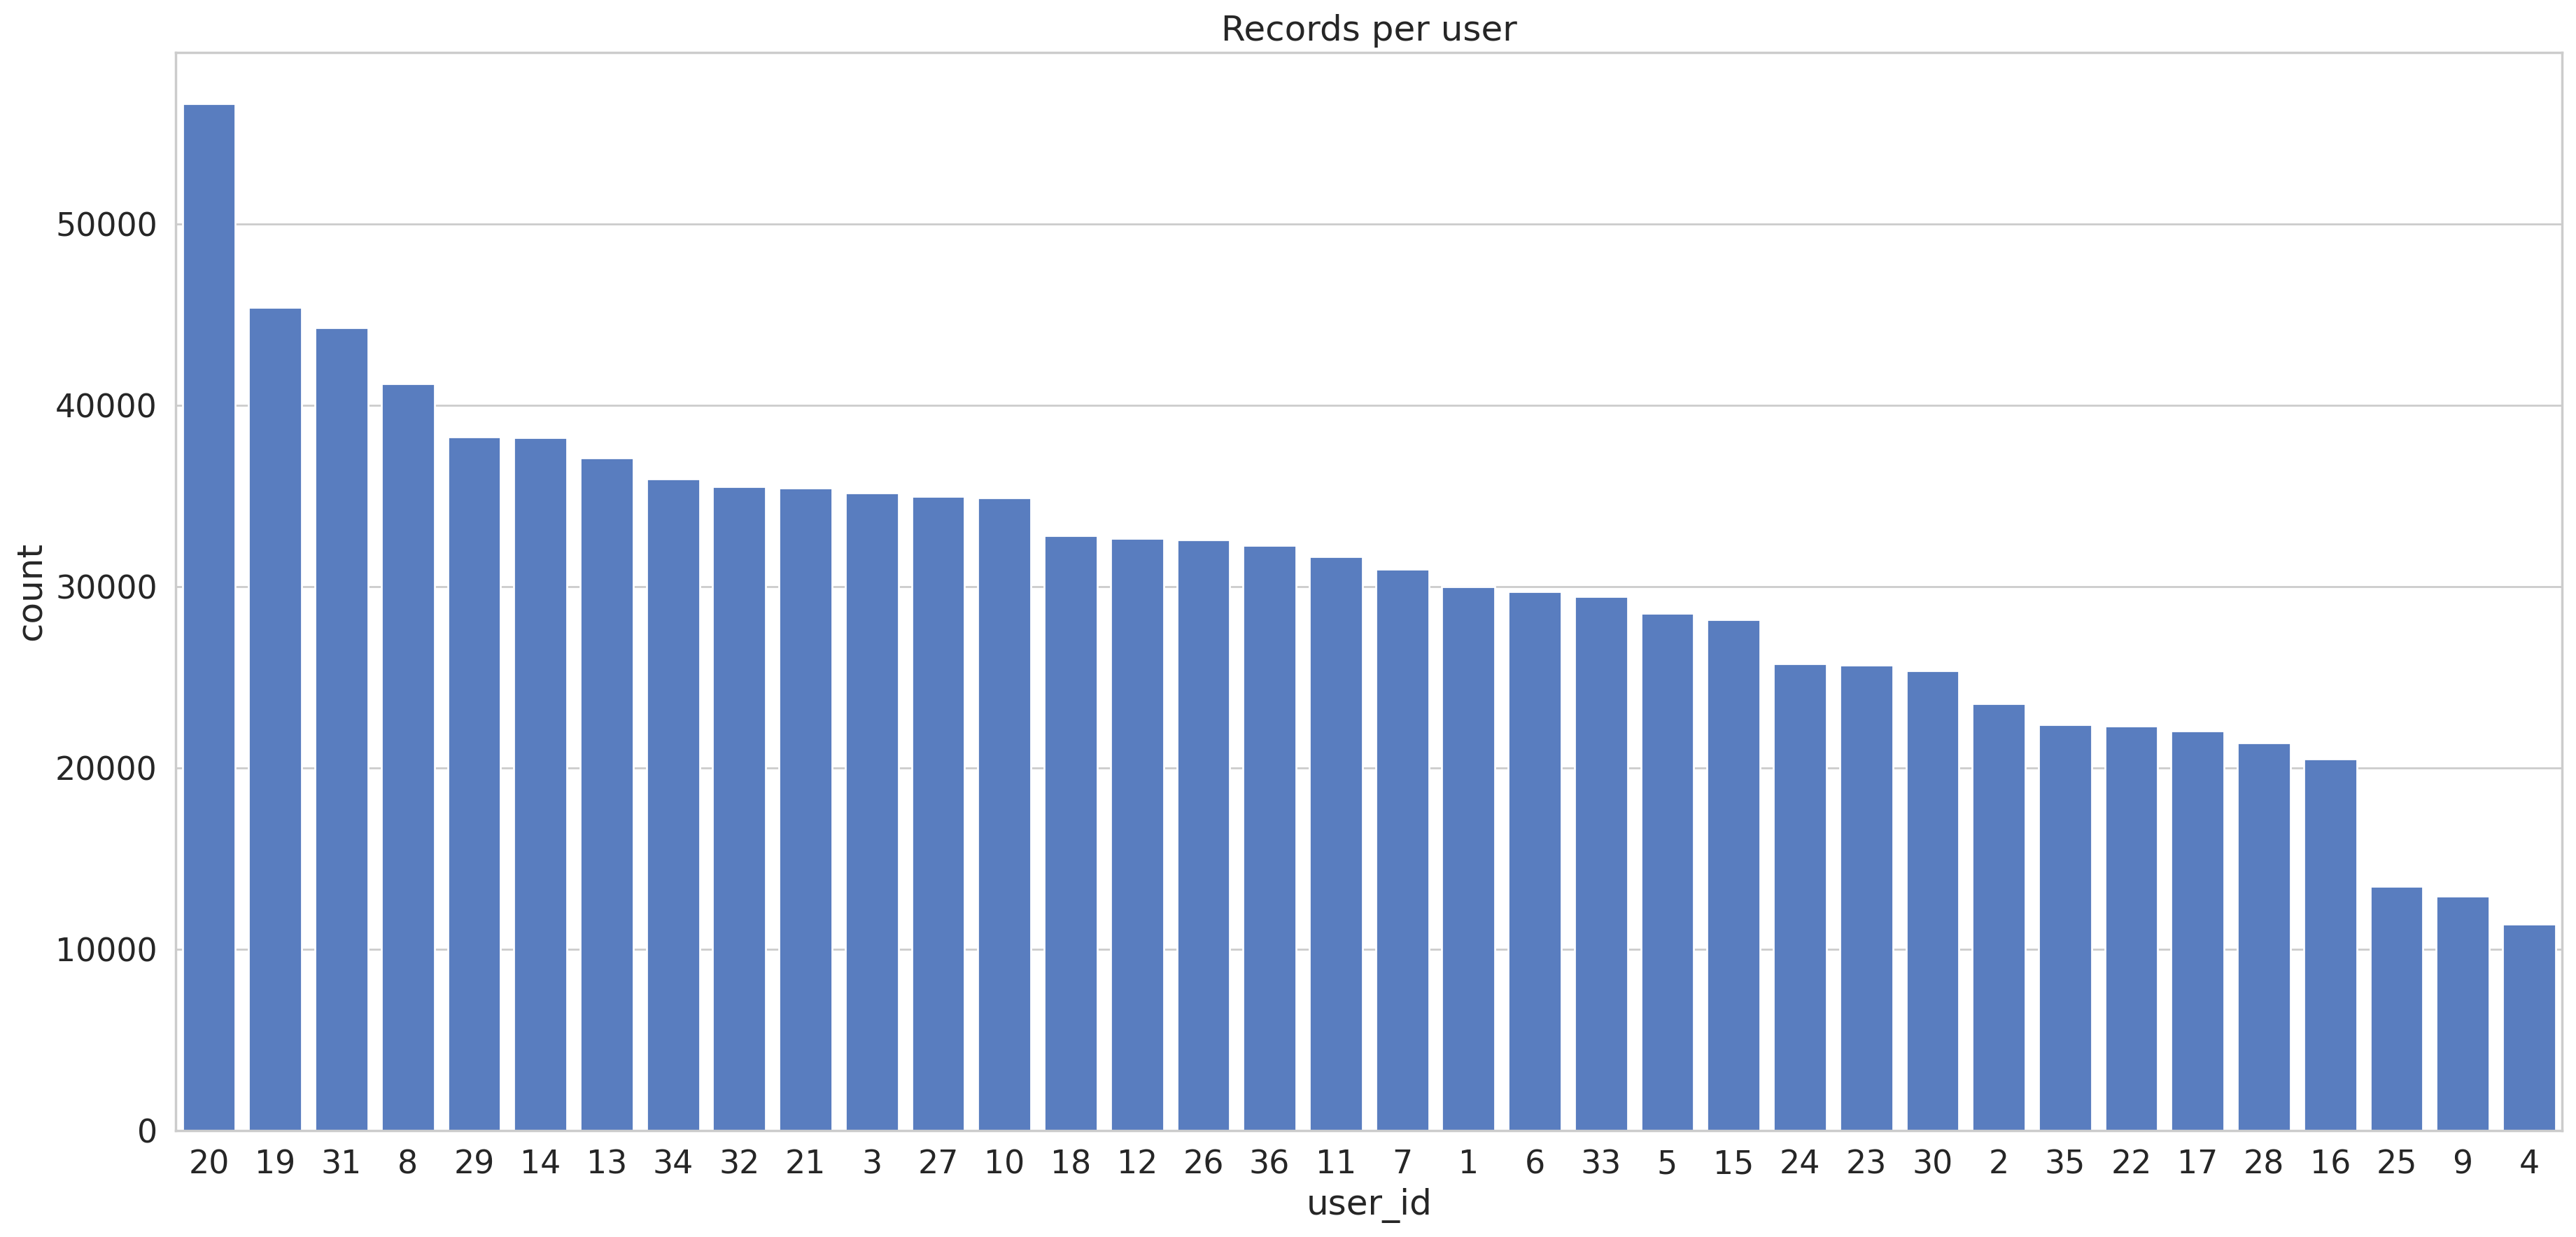

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


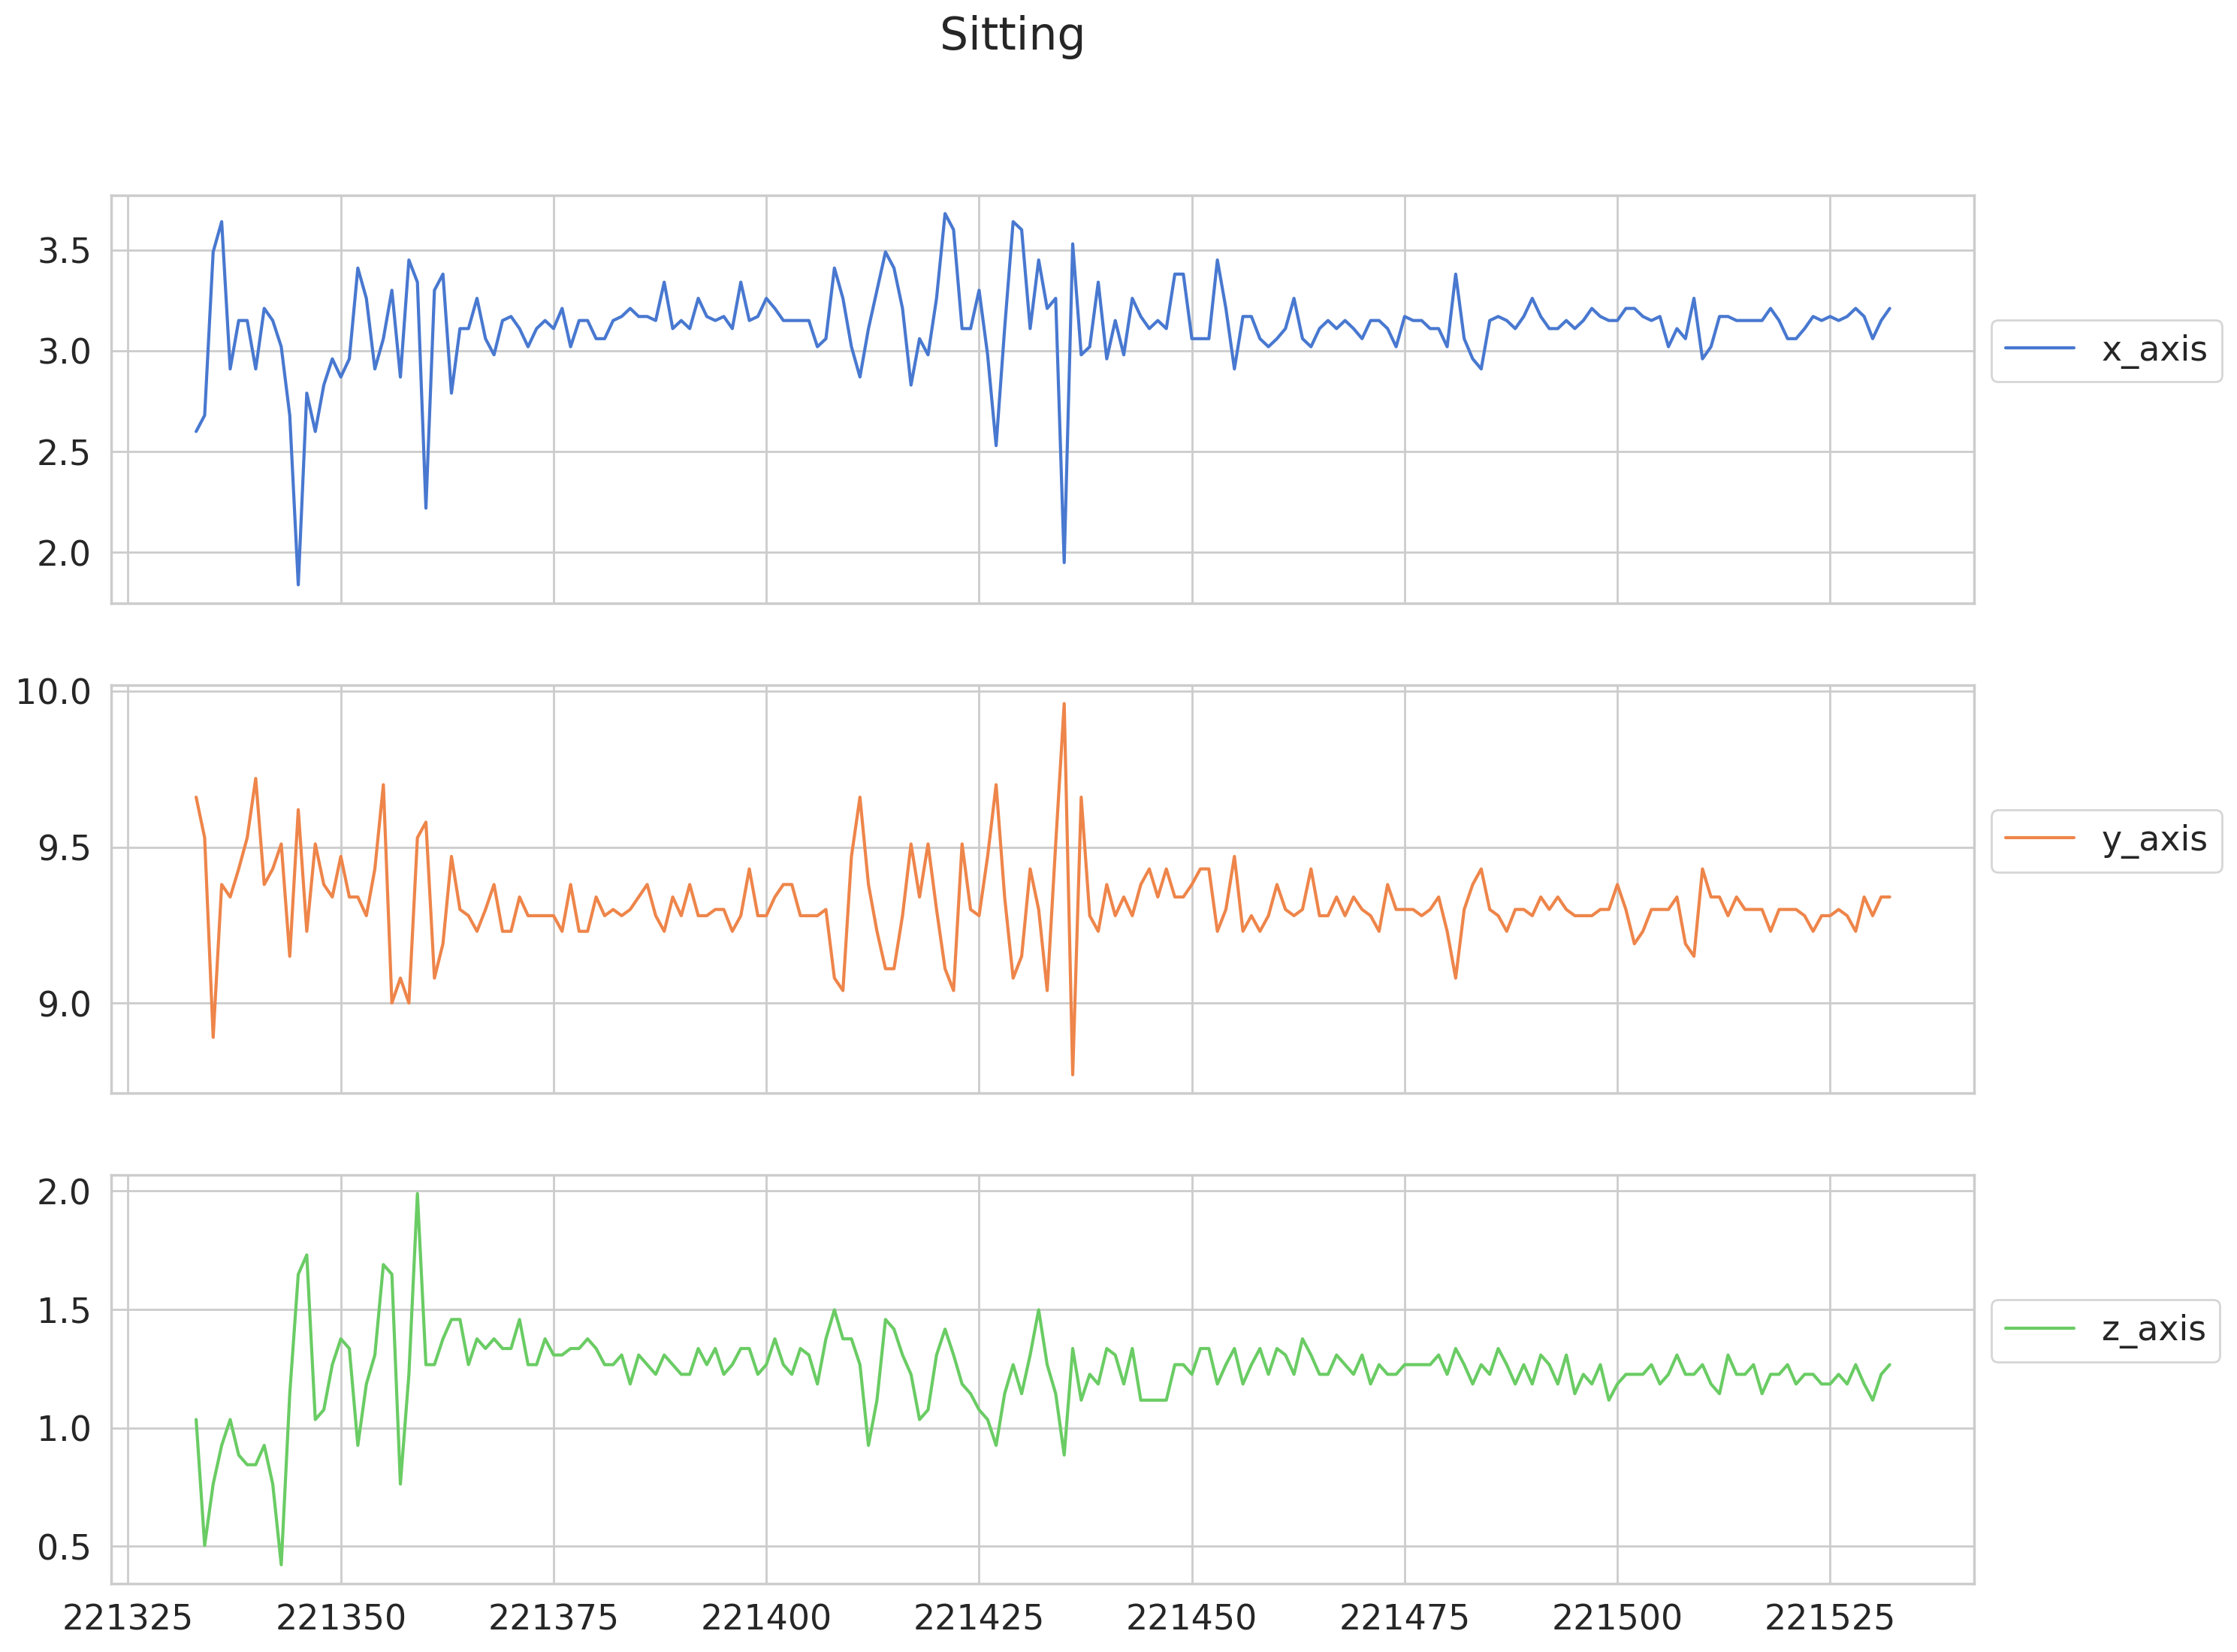

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


random_seed = 42

n_time_steps = 50

n_features = 3

step = 10

n_classes = 6

n_epochs = 50       

batch_size = 1024   

learning_rate = 0.0025

l2_loss = 0.0015


In [9]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id activity        timestamp    x_axis    y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.131961  0.566215  0.102015   
1             33  Jogging   49106062271000  0.648740  0.397381  0.193001   
2             33  Jogging   49106112167000  0.633834  0.351926 -0.016543   
3             33  Jogging   49106222305000 -0.120782  1.259408  0.612089   
4             33  Jogging   49106332290000 -0.199038  0.498032  1.458535   
...          ...      ...              ...       ...       ...       ...   
1098200       19  Sitting  131623331483000  1.194254 -1.132300  0.342105   
1098201       19  Sitting  131623371431000  1.199726 -1.119190  0.350202   
1098202       19  Sitting  131623411592000  1.205198 -1.109654  0.342105   
1098203       19  Sitting  131623491487000  1.194254 -1.119190  0.350202   
1098204       19  Sitting  131623531465000  1.177839 -1.103695  0.325911   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

In [10]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 10

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70281, 50, 3) (70281, 1)
(21964, 50, 3) (21964, 1)


In [11]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(70281, 50, 3) (70281, 6) (21964, 50, 3) (21964, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:

batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(50, 3, 6)

# LSTM1


In [18]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 76230 (297.77 KB)
Trainable params: 76230 (297.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# validation_split = 0.1
batch_size = 1024

train_epochs = 10

history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
69/69 [==============================] - 6s 31ms/step - loss: 1.1921 - accuracy: 0.5861 - val_loss: 0.8481 - val_accuracy: 0.7155
Epoch 2/10
69/69 [==============================] - 1s 18ms/step - loss: 0.7459 - accuracy: 0.7463 - val_loss: 0.6144 - val_accuracy: 0.7813
Epoch 3/10
69/69 [==============================] - 1s 17ms/step - loss: 0.5890 - accuracy: 0.7916 - val_loss: 0.5538 - val_accuracy: 0.7940
Epoch 4/10
69/69 [==============================] - 1s 17ms/step - loss: 0.5209 - accuracy: 0.8116 - val_loss: 0.4790 - val_accuracy: 0.8206
Epoch 5/10
69/69 [==============================] - 1s 17ms/step - loss: 0.4666 - accuracy: 0.8286 - val_loss: 0.4233 - val_accuracy: 0.8416
Epoch 6/10
69/69 [==============================] - 1s 17ms/step - loss: 0.4271 - accuracy: 0.8408 - val_loss: 0.3864 - val_accuracy: 0.8465
Epoch 7/10
69/69 [==============================] - 1s 19ms/step - loss: 0.3934 - accuracy: 0.8504 - val_loss: 0.3481 - val_accuracy: 0.8675
Epoch 8/10
69

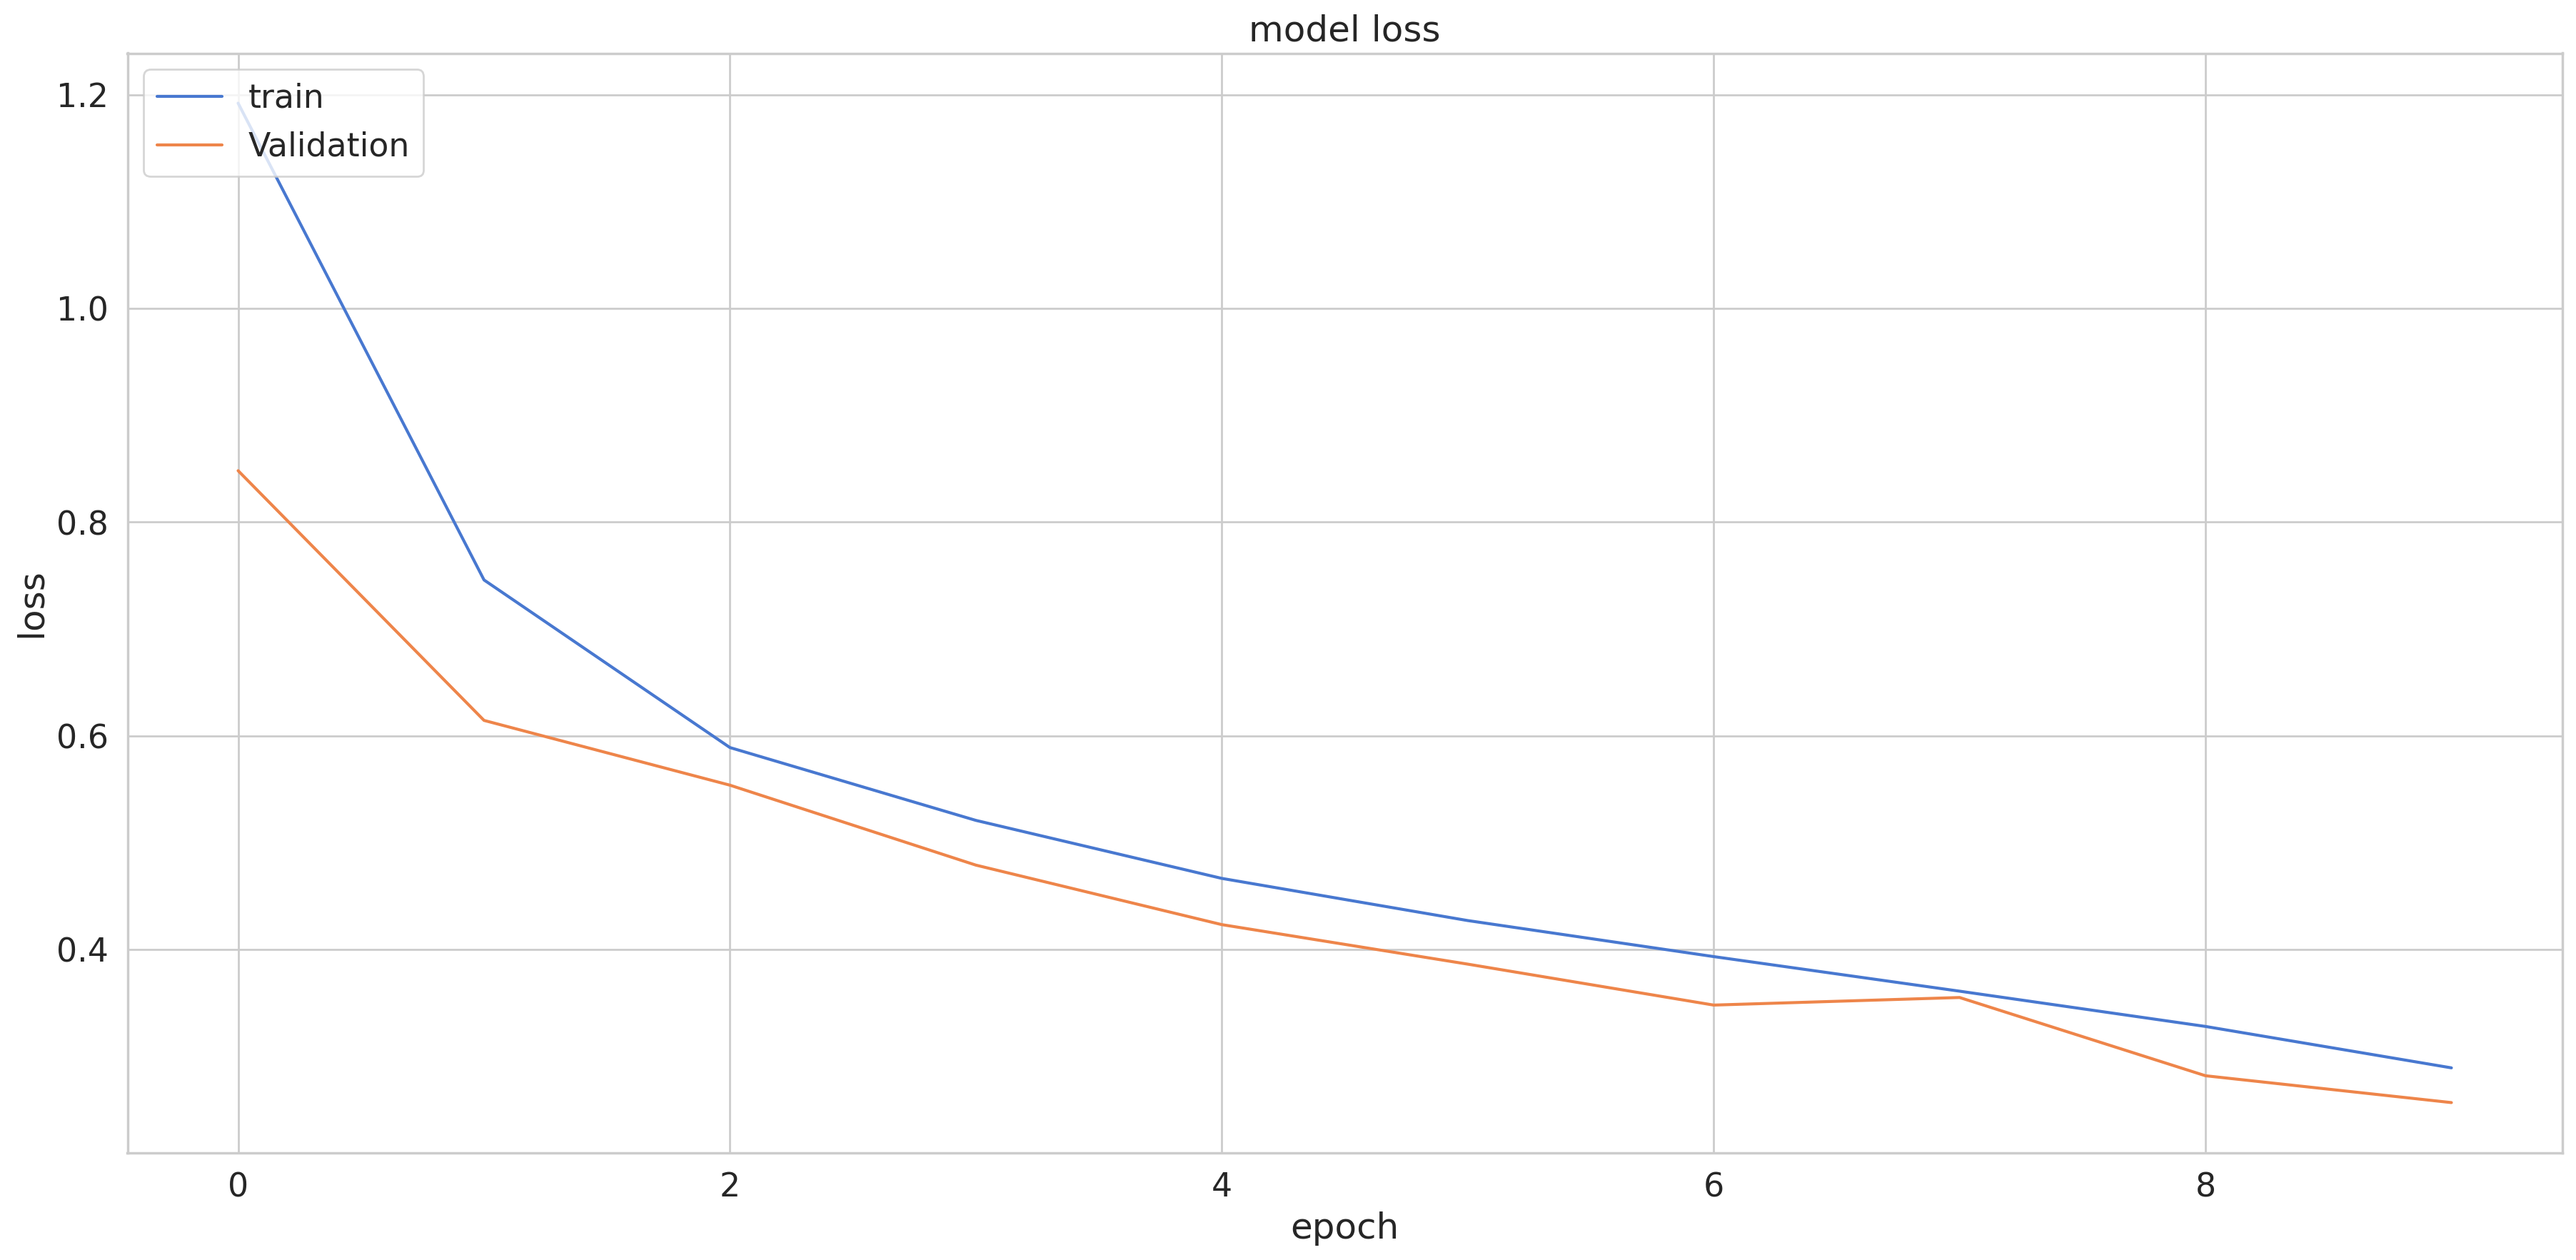

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

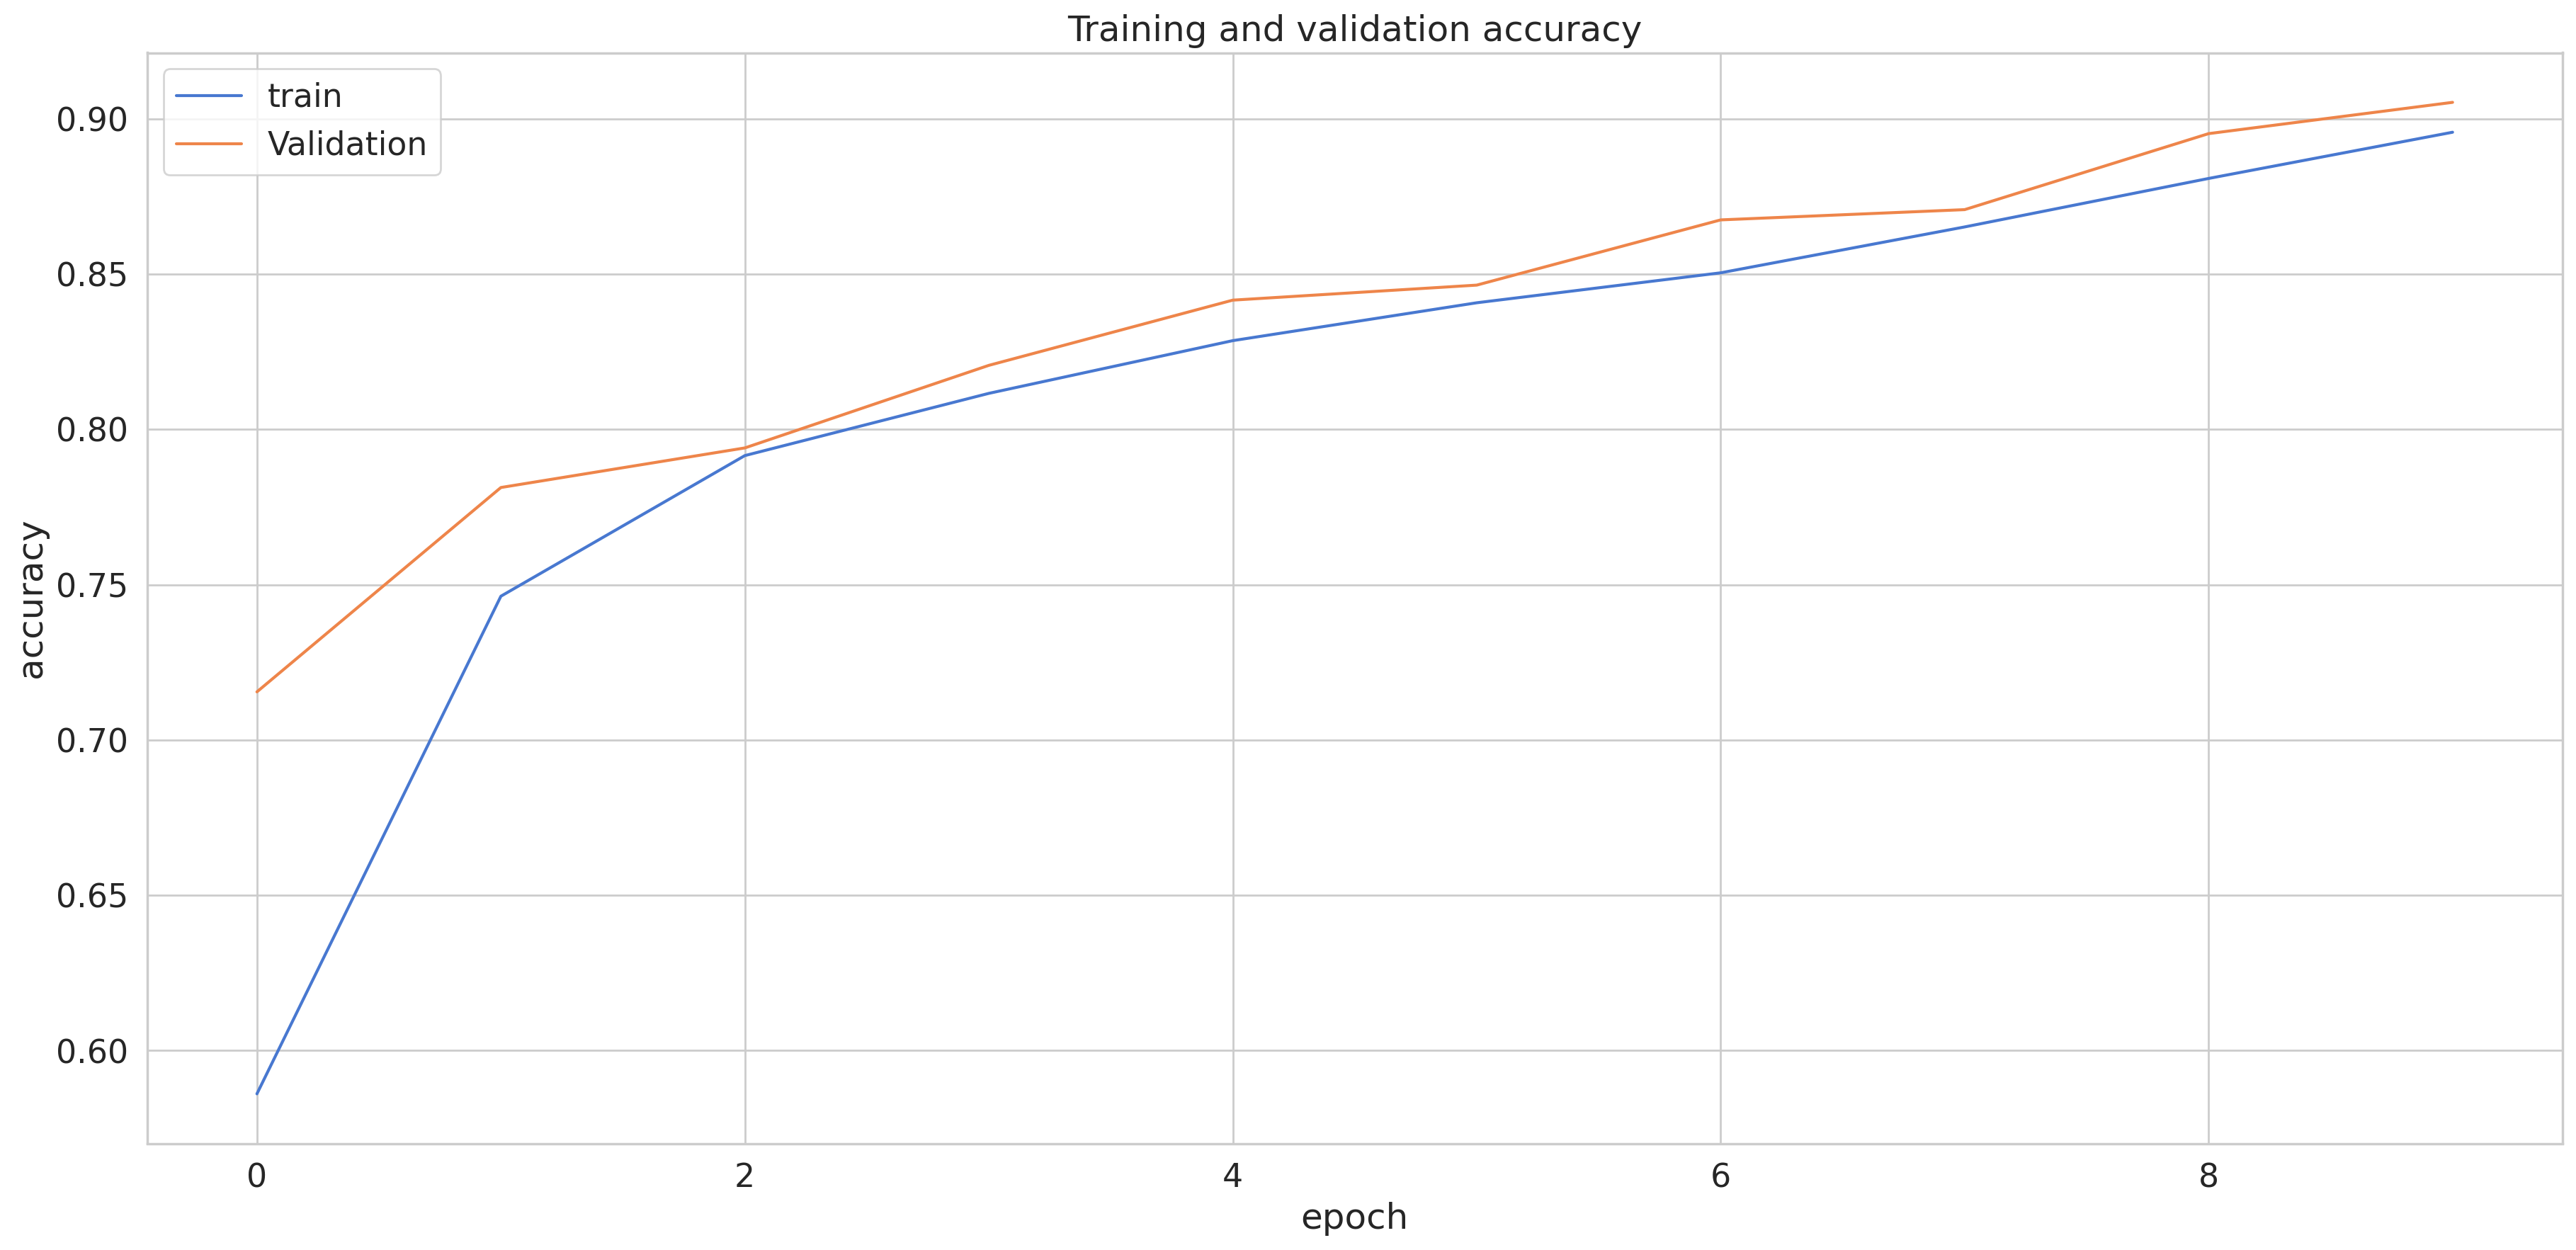

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 2s 3ms/step
f1_score =  0.9100836836656665
0.9122655254052086
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8489
           1       0.96      0.99      0.97      6844
           2       0.79      0.71      0.75      2458
           3       0.71      0.65      0.68      2007
           4       0.96      0.96      0.96      1198
           5       0.94      0.97      0.96       968

    accuracy                           0.91     21964
   macro avg       0.88      0.87      0.88     21964
weighted avg       0.91      0.91      0.91     21964



<Axes: >

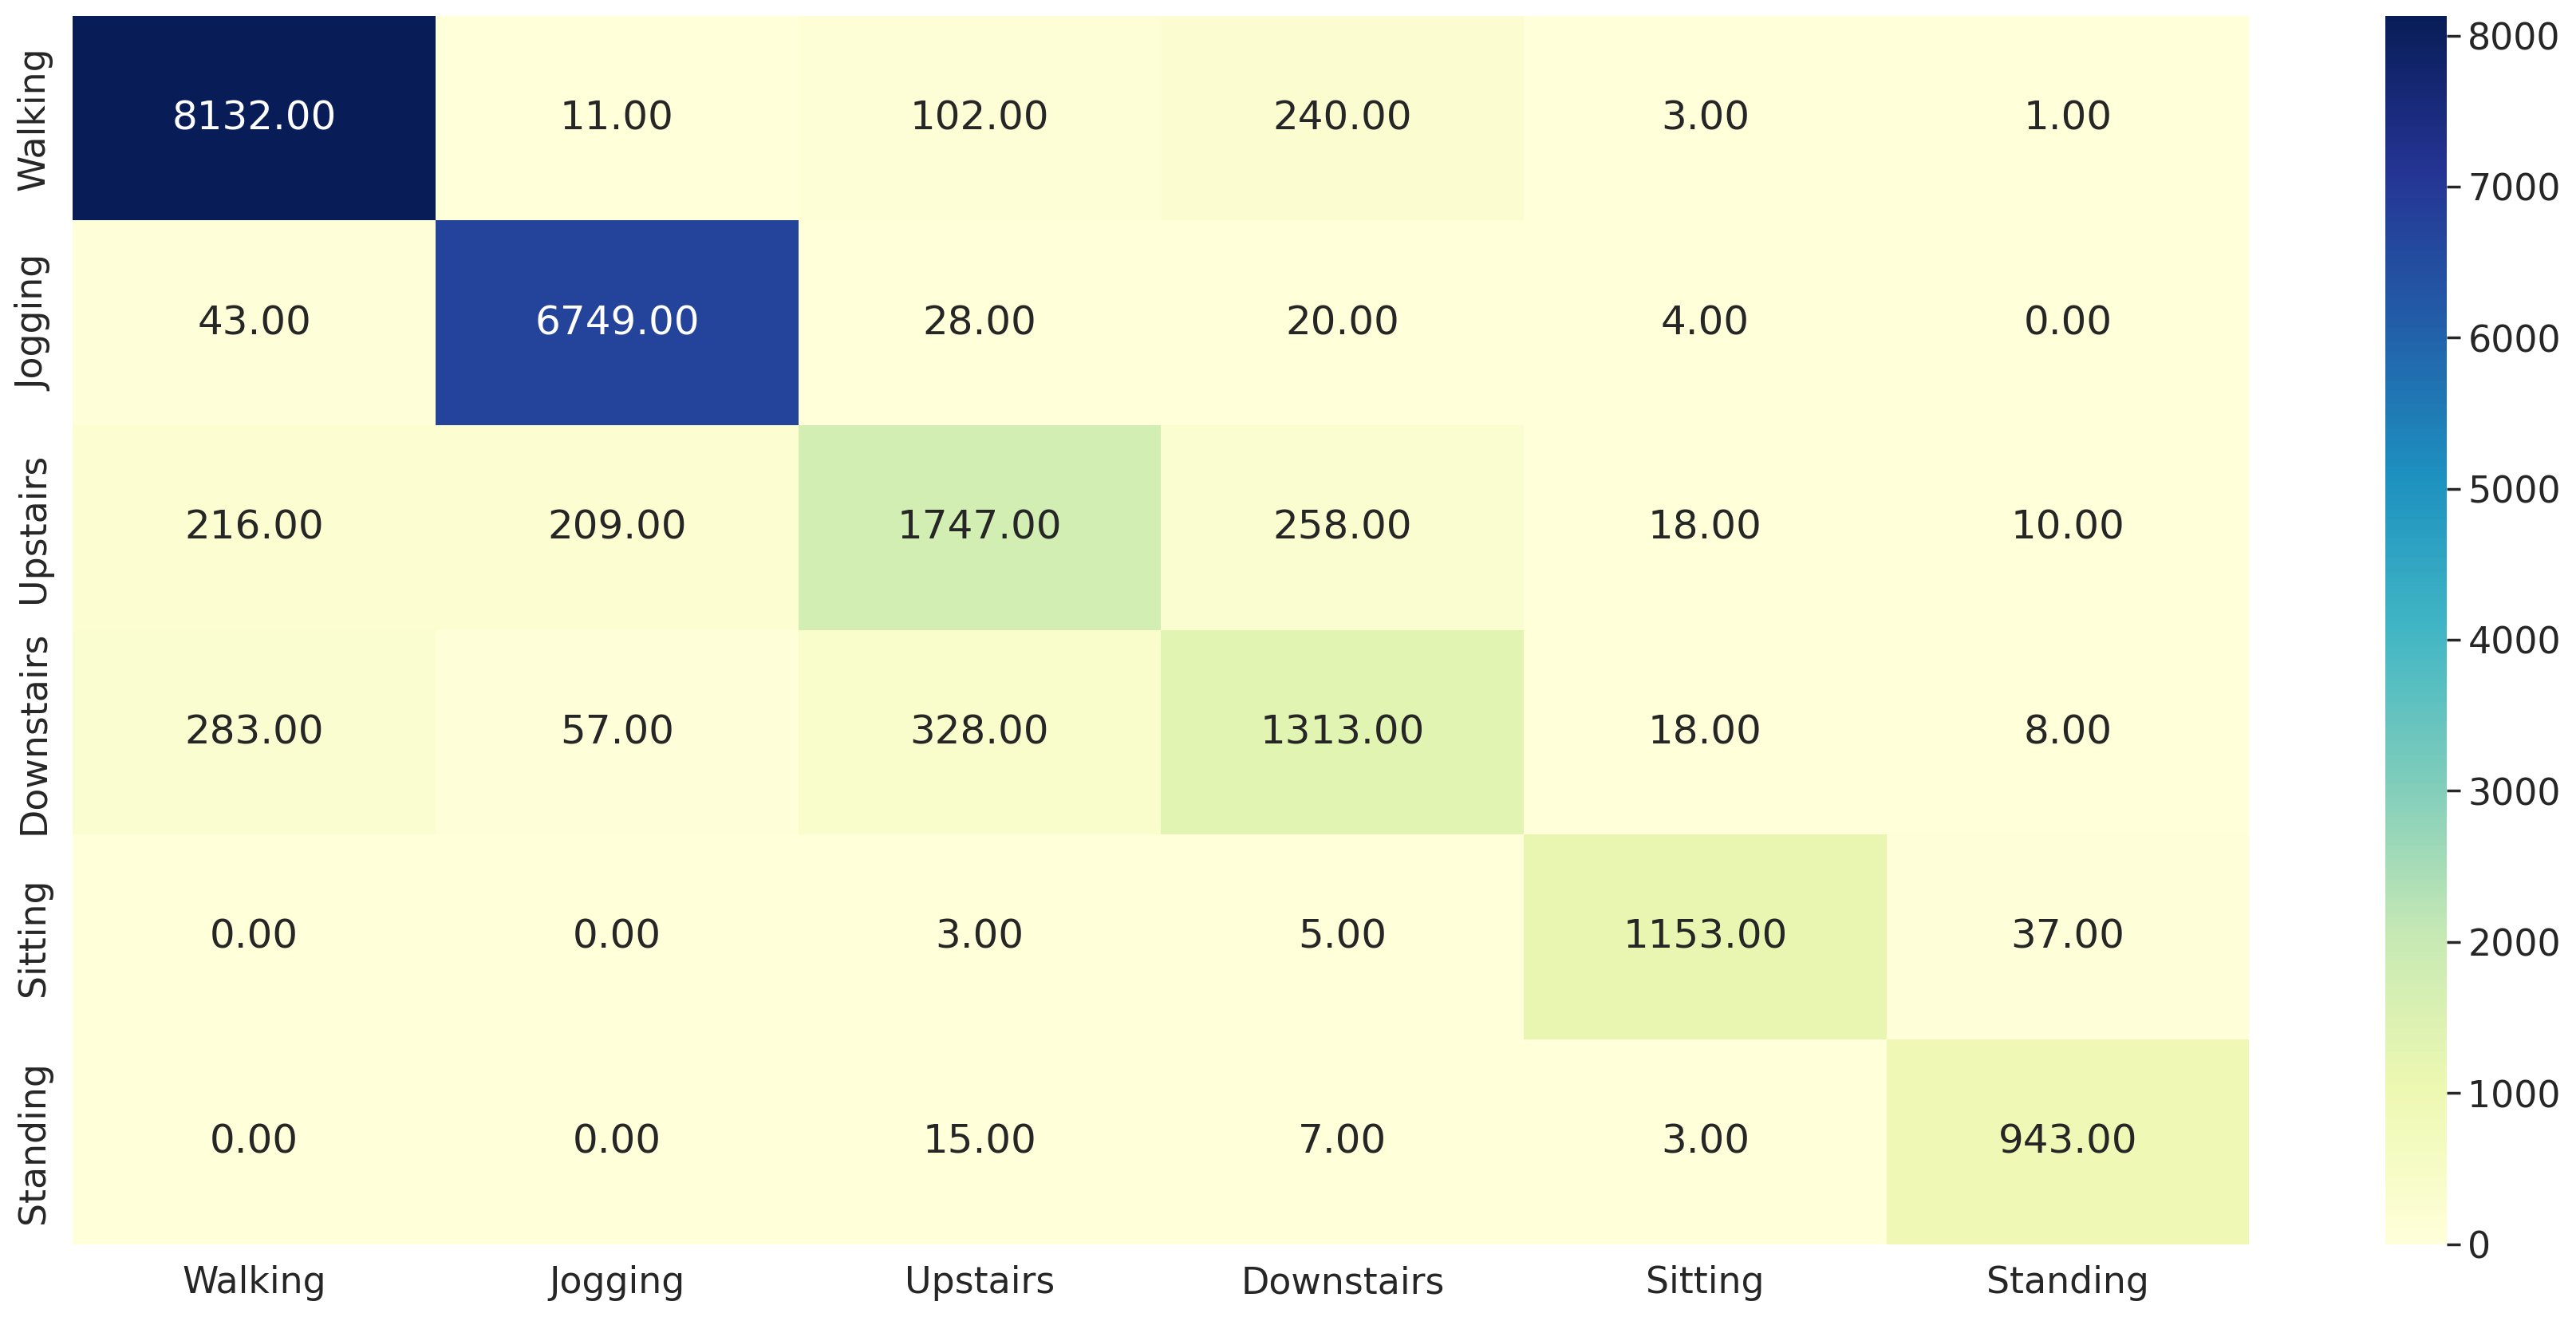

In [22]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50, 128)           67584     
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 207814 (811.77 KB)
Trainable params: 207

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 10s 13ms/step - loss: 0.6658 - accuracy: 0.7687 - val_loss: 0.4620 - val_accuracy: 0.8281
Epoch 2/10
550/550 [==============================] - 6s 11ms/step - loss: 0.3363 - accuracy: 0.8839 - val_loss: 0.2489 - val_accuracy: 0.9146
Epoch 3/10
550/550 [==============================] - 5s 10ms/step - loss: 0.2185 - accuracy: 0.9296 - val_loss: 0.1643 - val_accuracy: 0.9466
Epoch 4/10
550/550 [==============================] - 6s 11ms/step - loss: 0.1676 - accuracy: 0.9478 - val_loss: 0.1664 - val_accuracy: 0.9466
Epoch 5/10
550/550 [==============================] - 5s 10ms/step - loss: 0.1427 - accuracy: 0.9559 - val_loss: 0.1229 - val_accuracy: 0.9615
Epoch 6/10
550/550 [==============================] - 6s 10ms/step - loss: 0.1206 - accuracy: 0.9627 - val_loss: 0.0975 - val_accuracy: 0.9675
Epoch 7/10
550/550 [==============================] - 6s 11ms/step - loss: 0.0990 - accuracy: 0.9687 - val_loss: 0.1061 - val_accuracy: 0.968

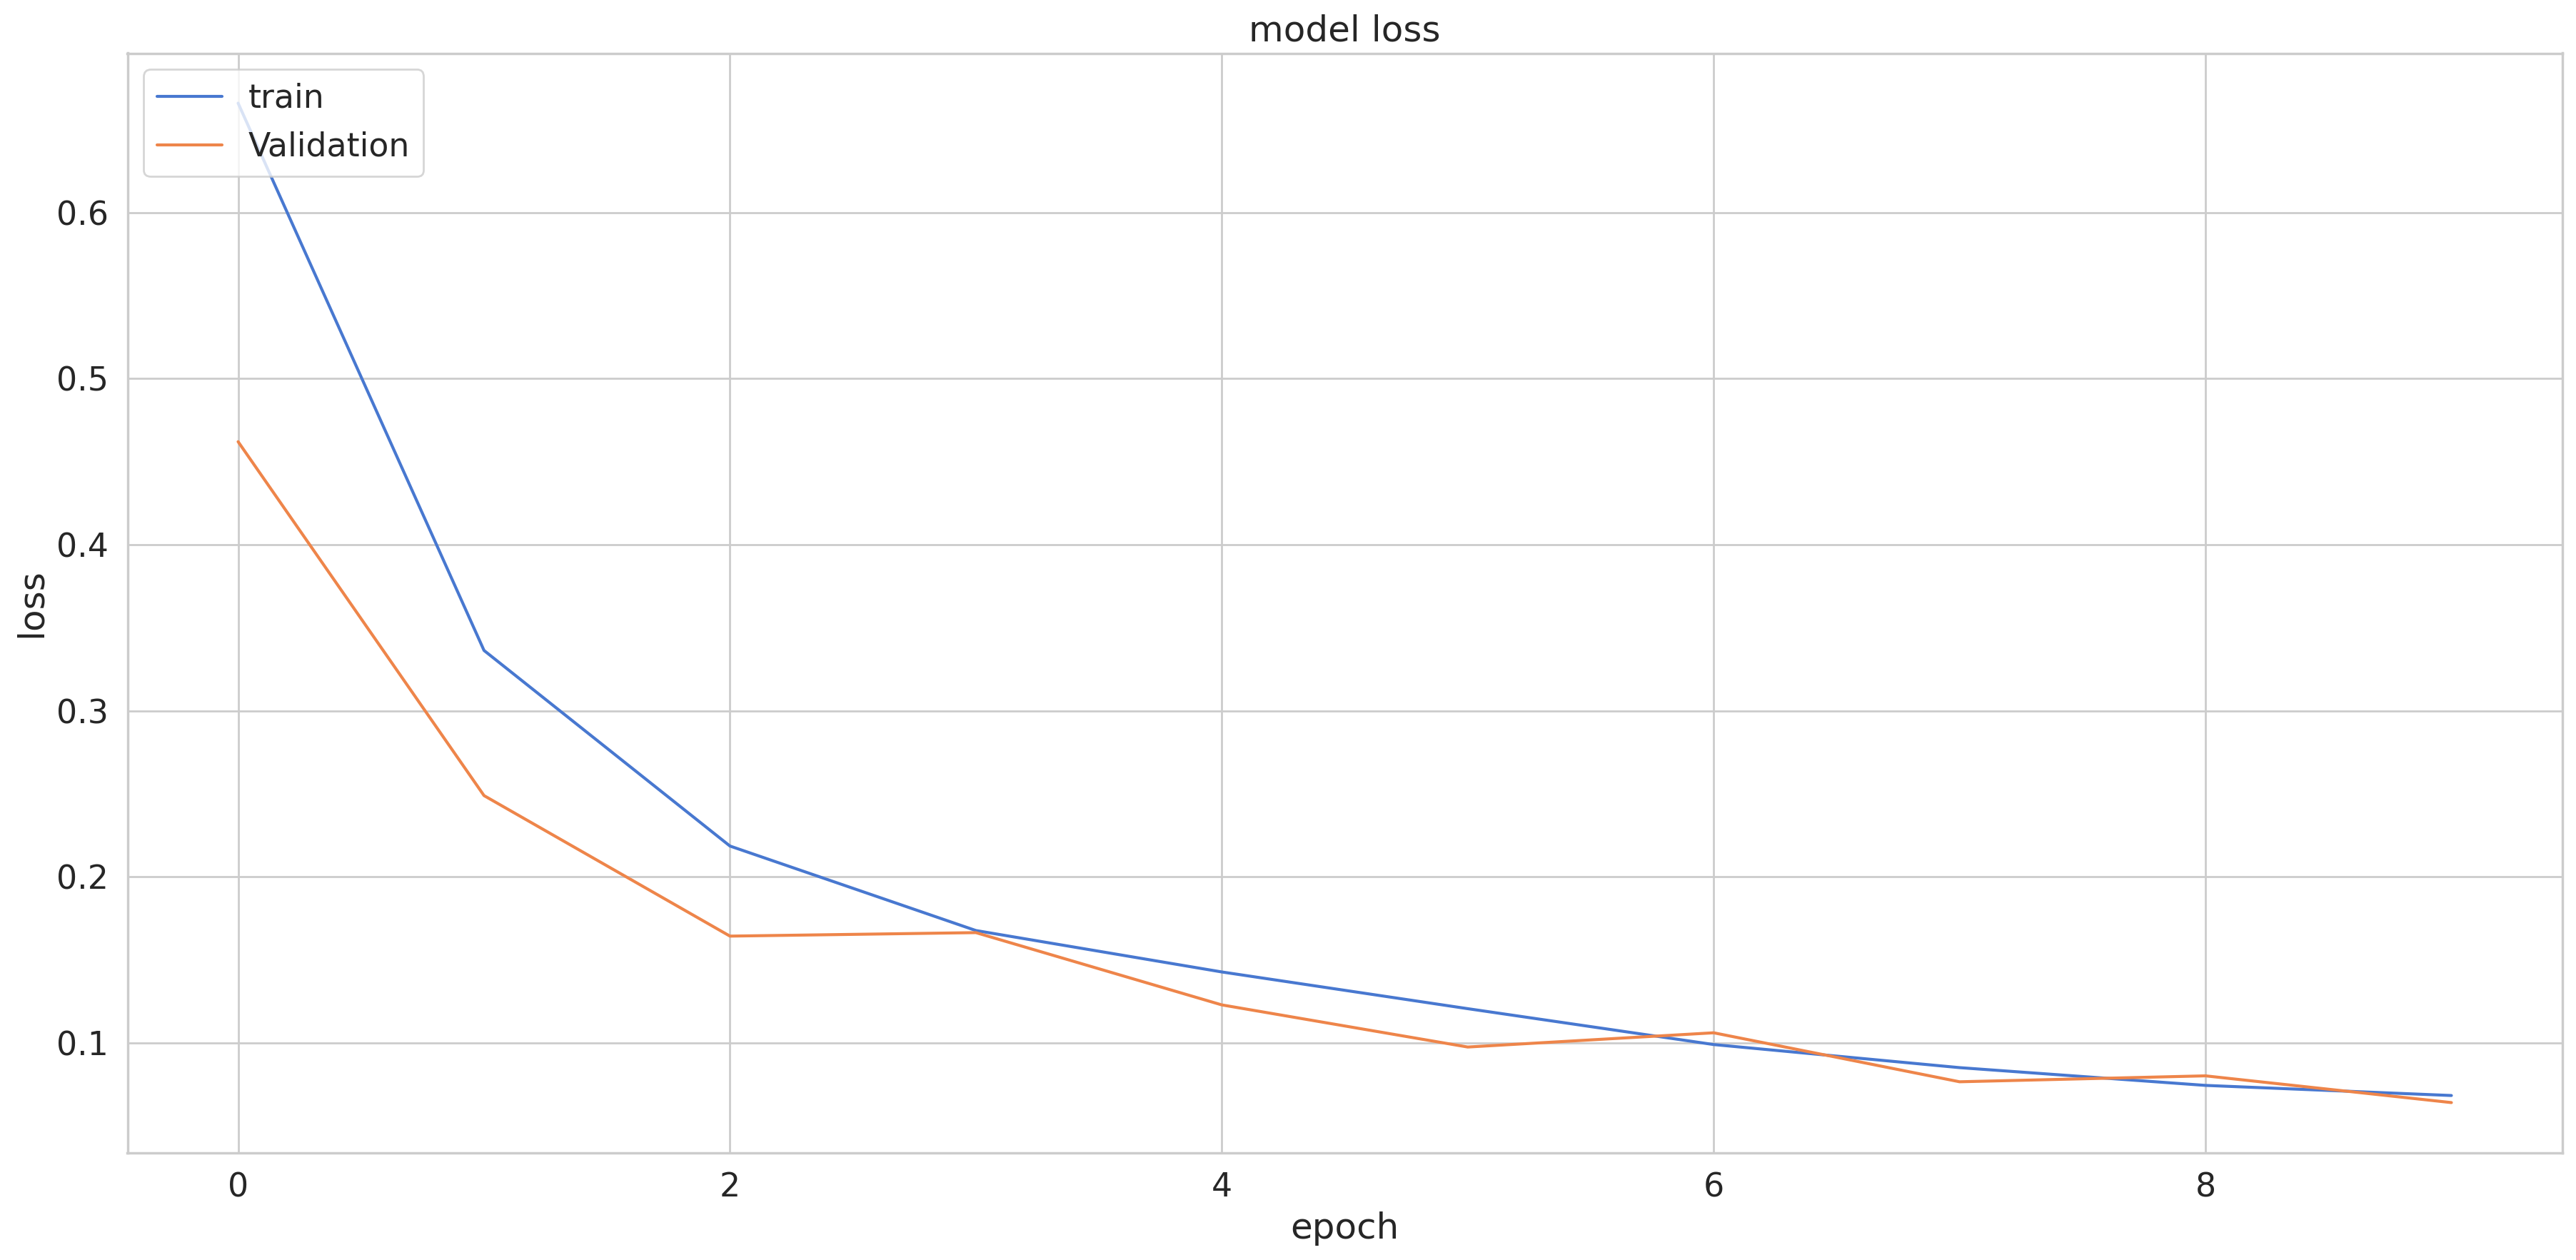

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

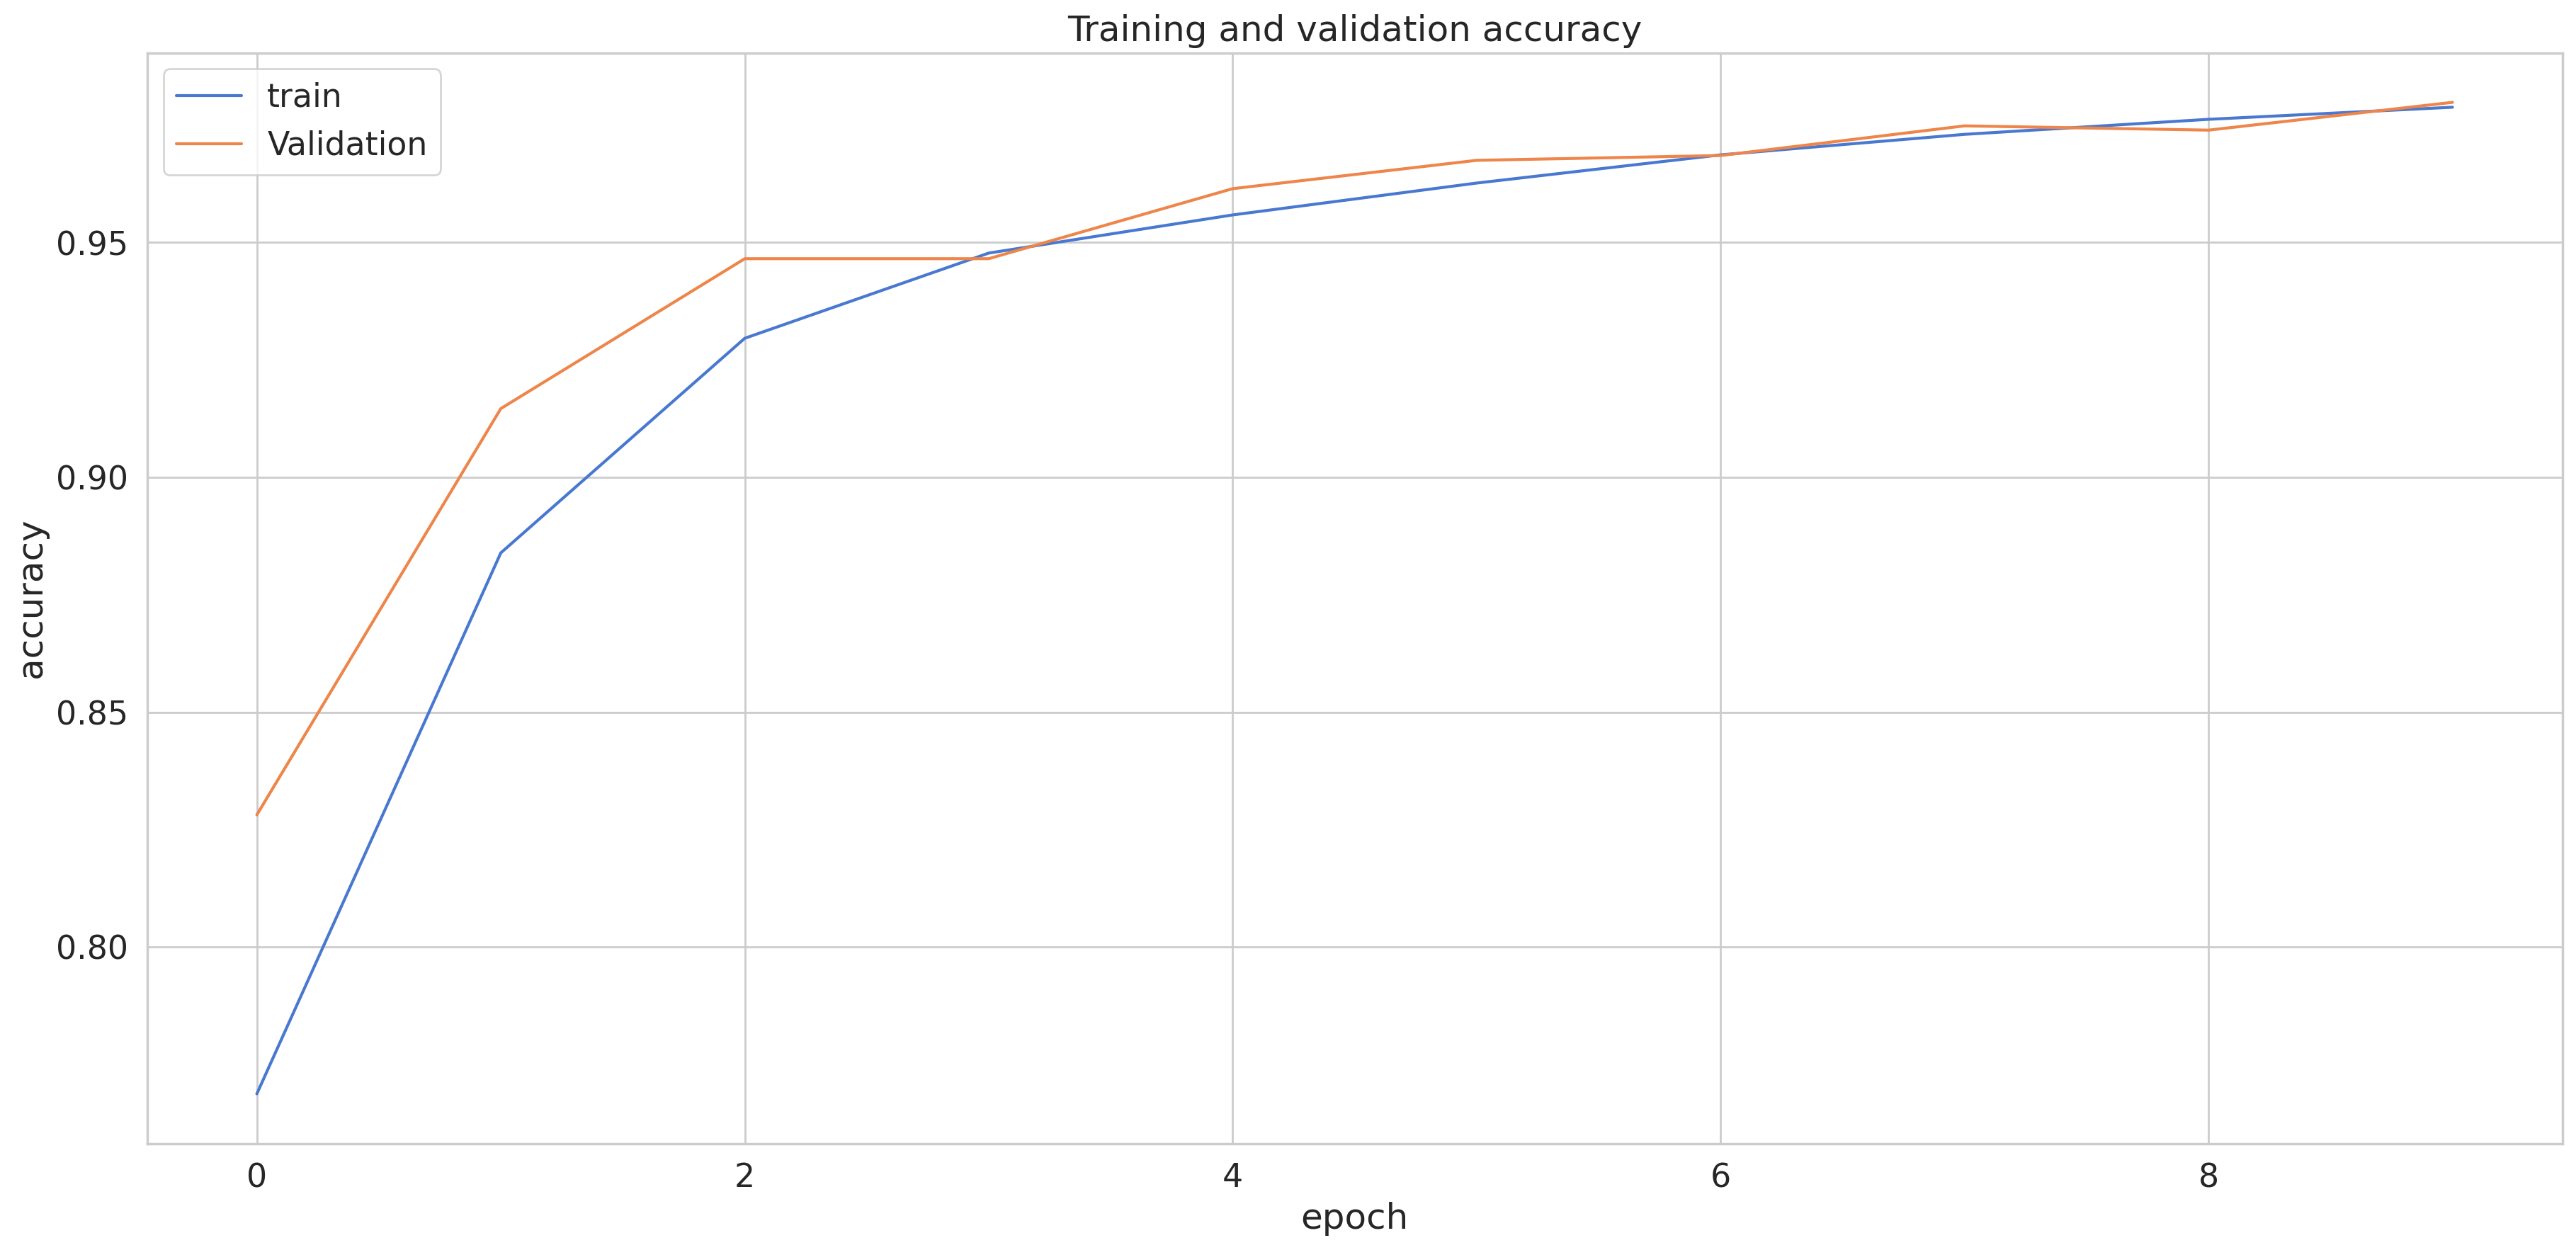

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 3s 4ms/step
f1_score =  0.9798995865546205
0.9798761609907121
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8489
           1       1.00      0.99      0.99      6844
           2       0.94      0.93      0.93      2458
           3       0.92      0.94      0.93      2007
           4       0.99      0.99      0.99      1198
           5       0.98      0.99      0.99       968

    accuracy                           0.98     21964
   macro avg       0.97      0.97      0.97     21964
weighted avg       0.98      0.98      0.98     21964



<Axes: >

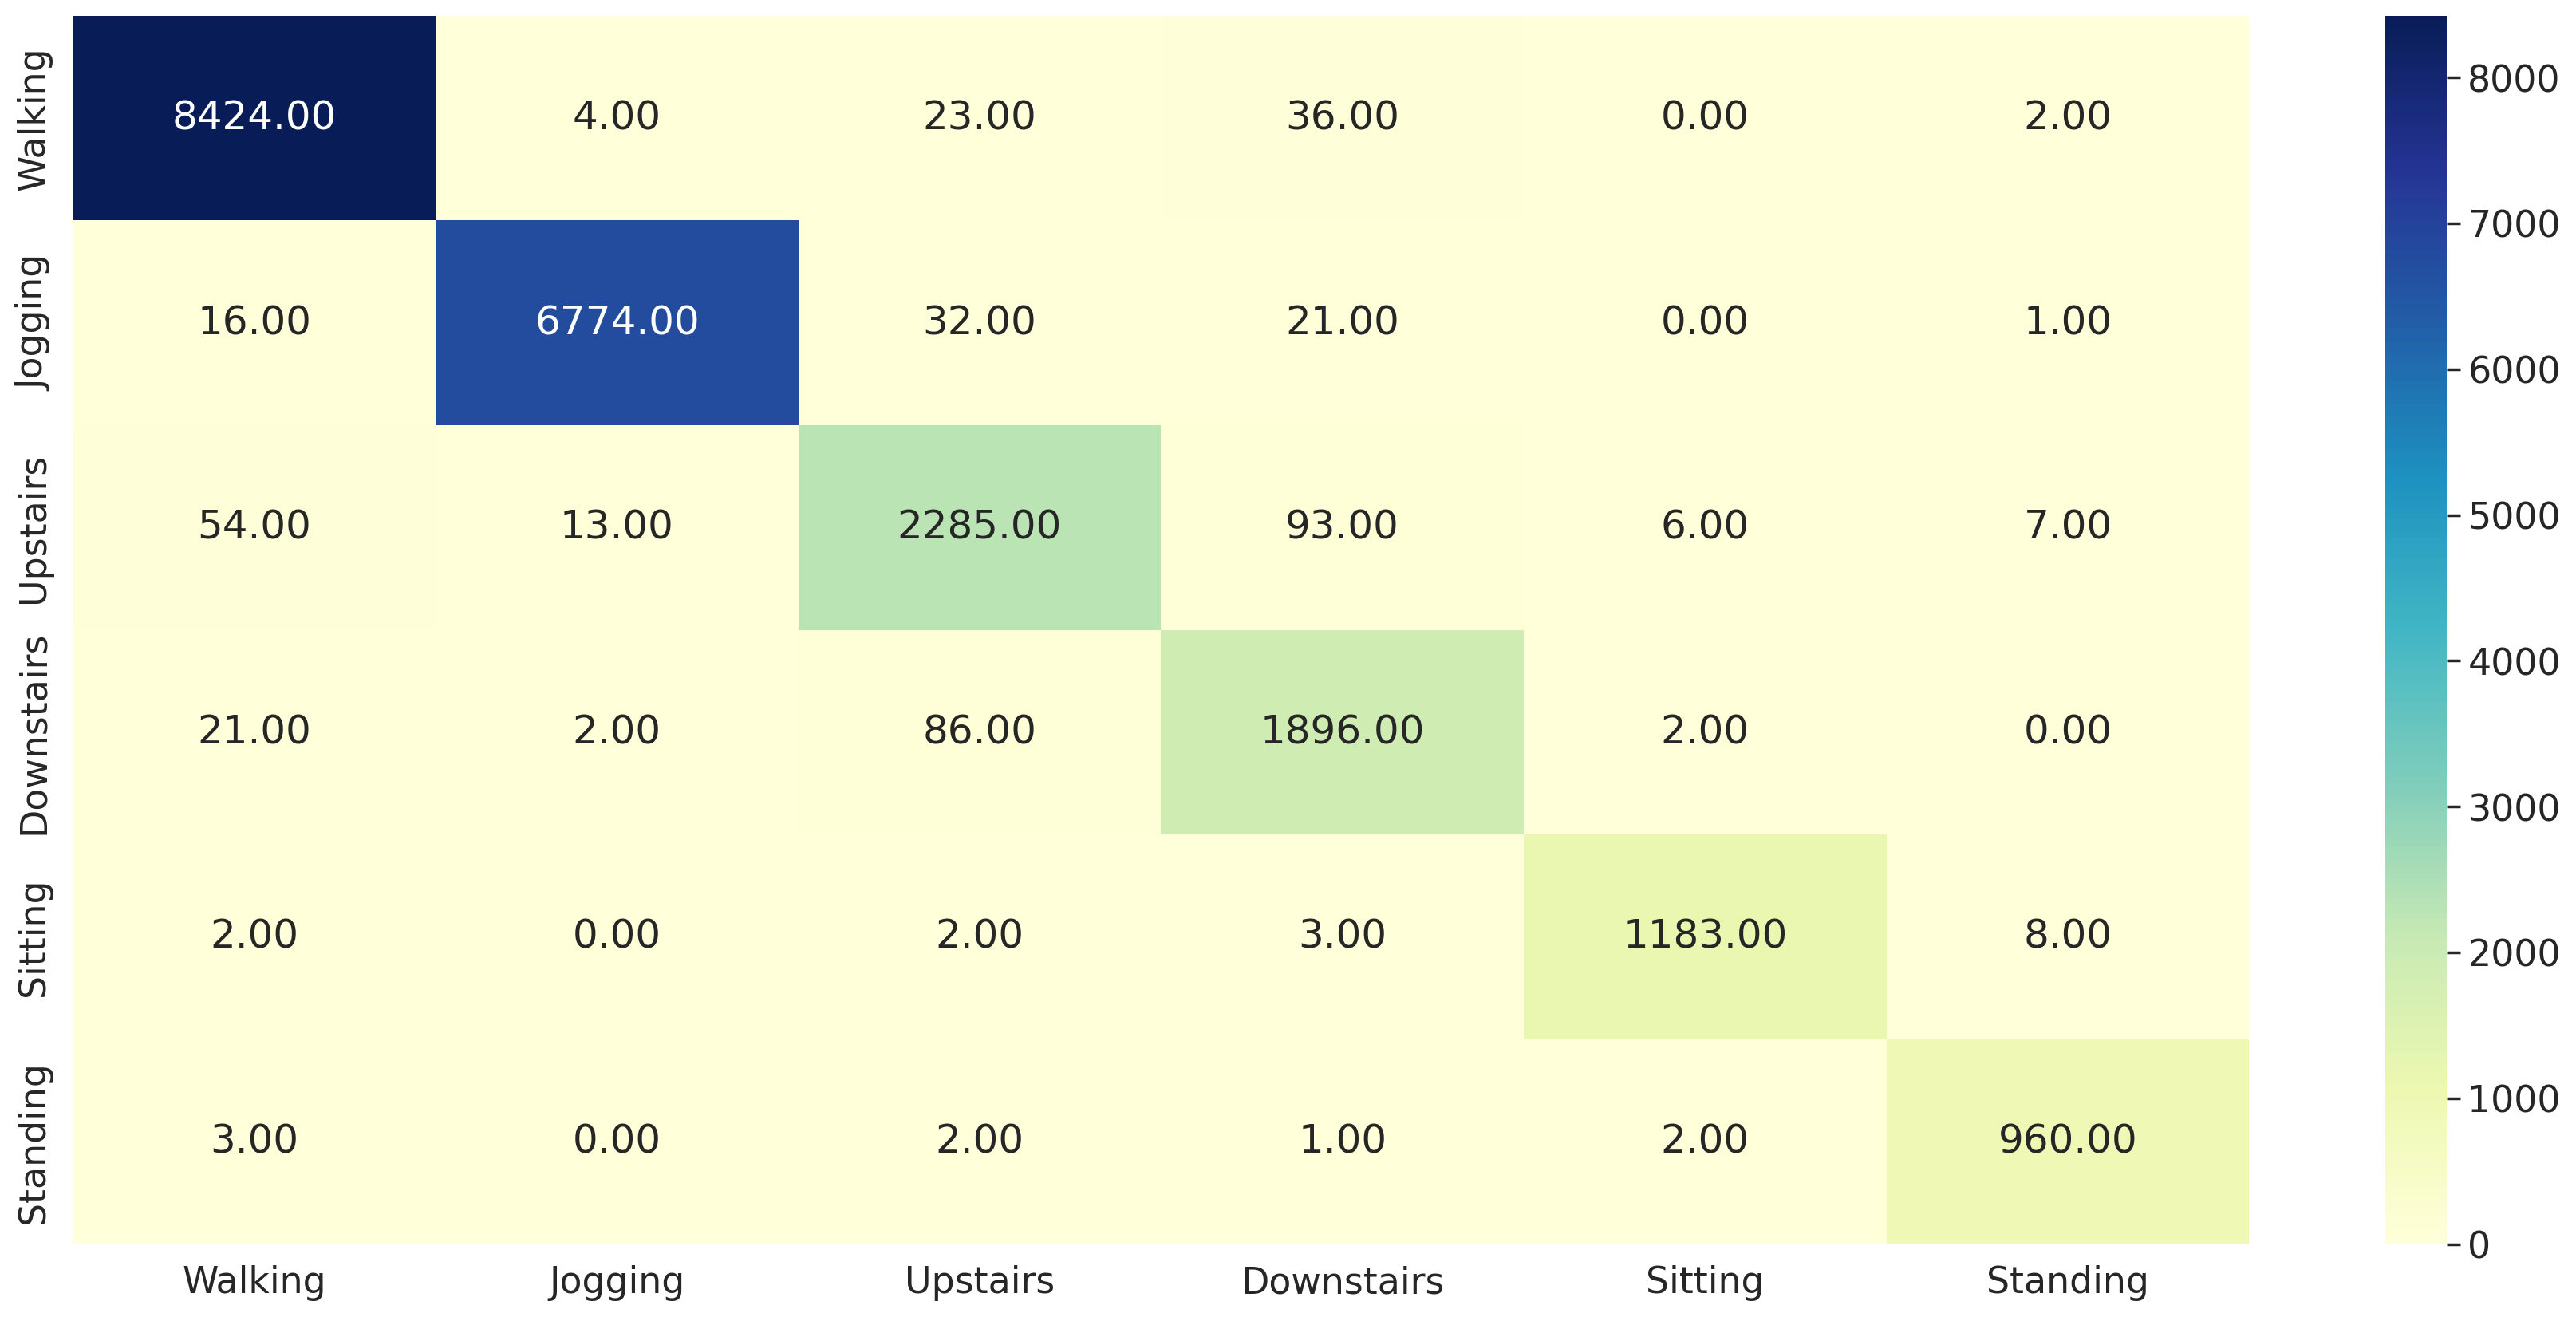

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM3

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 128)           67584     
                                                                 
 dropout_3 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_4 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 15s 16ms/step - loss: 0.6616 - accuracy: 0.7705 - val_loss: 0.4637 - val_accuracy: 0.8328
Epoch 2/10
550/550 [==============================] - 8s 15ms/step - loss: 0.3388 - accuracy: 0.8832 - val_loss: 0.2290 - val_accuracy: 0.9239
Epoch 3/10
550/550 [==============================] - 8s 14ms/step - loss: 0.2045 - accuracy: 0.9361 - val_loss: 0.1669 - val_accuracy: 0.9449
Epoch 4/10
550/550 [==============================] - 8s 15ms/step - loss: 0.1636 - accuracy: 0.9491 - val_loss: 0.1221 - val_accuracy: 0.9596
Epoch 5/10
550/550 [==============================] - 8s 15ms/step - loss: 0.1279 - accuracy: 0.9603 - val_loss: 0.1069 - val_accuracy: 0.9653
Epoch 6/10
550/550 [==============================] - 9s 17ms/step - loss: 0.1075 - accuracy: 0.9656 - val_loss: 0.1151 - val_accuracy: 0.9612
Epoch 7/10
550/550 [==============================] - 9s 16ms/step - loss: 0.0931 - accuracy: 0.9702 - val_loss: 0.1083 - val_accuracy: 0.967

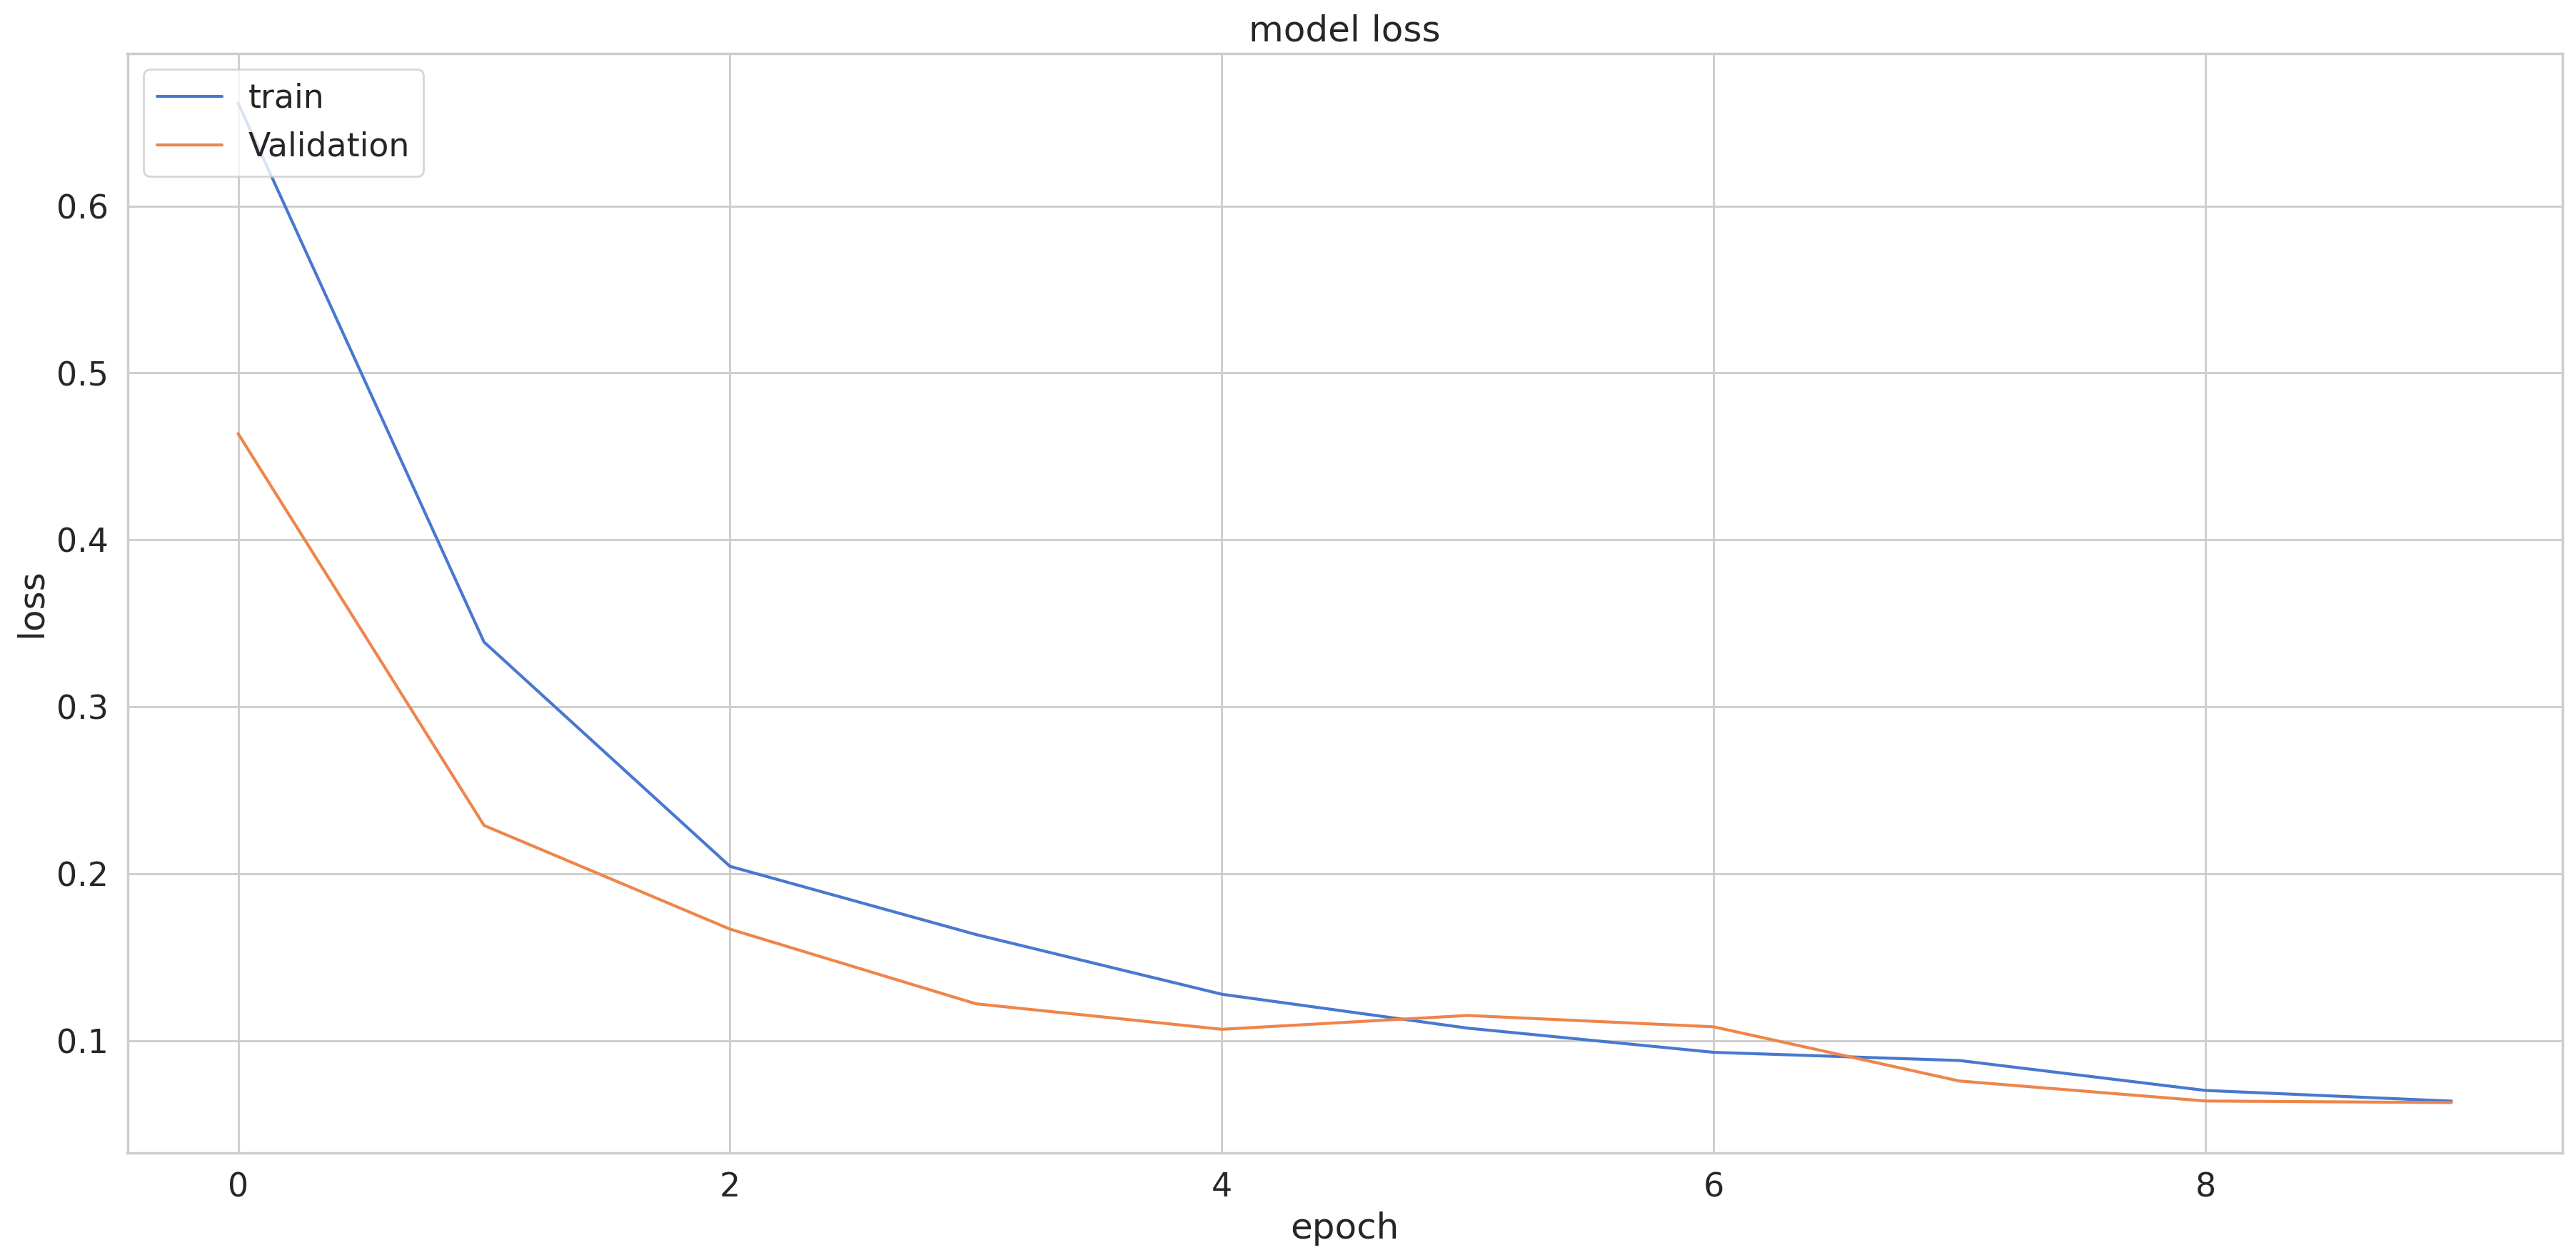

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

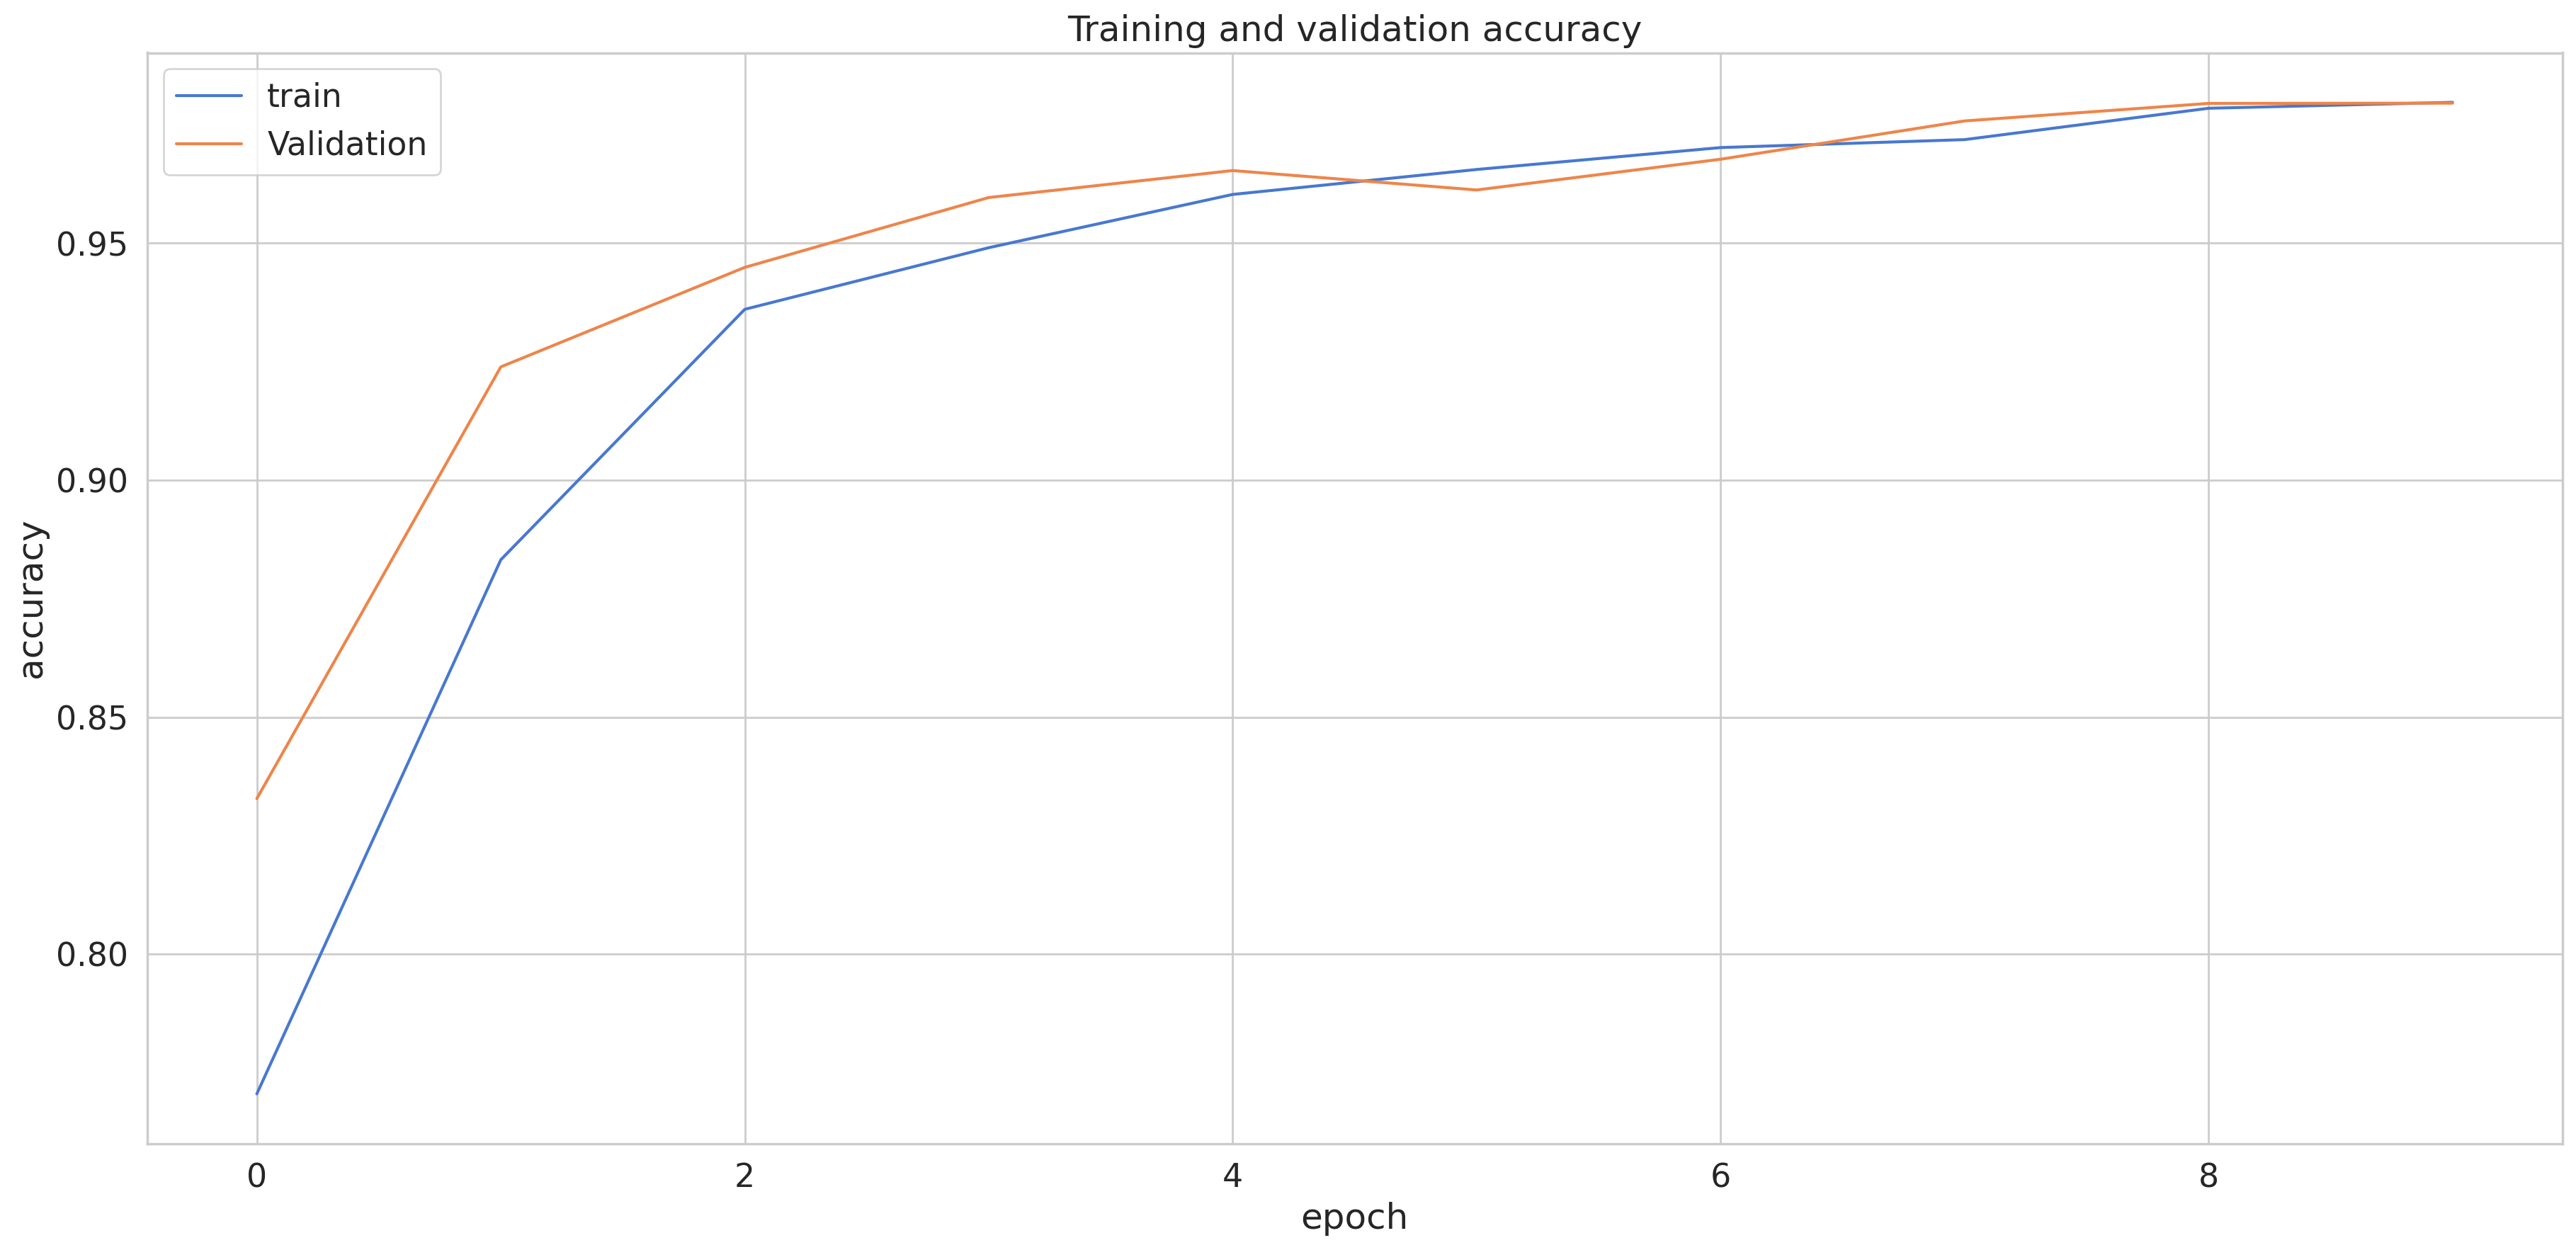

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 5s 5ms/step
f1_score =  0.9791492674236898
0.9791021671826625
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8489
           1       1.00      0.99      0.99      6844
           2       0.94      0.95      0.94      2458
           3       0.94      0.94      0.94      2007
           4       0.99      0.95      0.97      1198
           5       0.93      1.00      0.96       968

    accuracy                           0.98     21964
   macro avg       0.96      0.97      0.97     21964
weighted avg       0.98      0.98      0.98     21964



<Axes: >

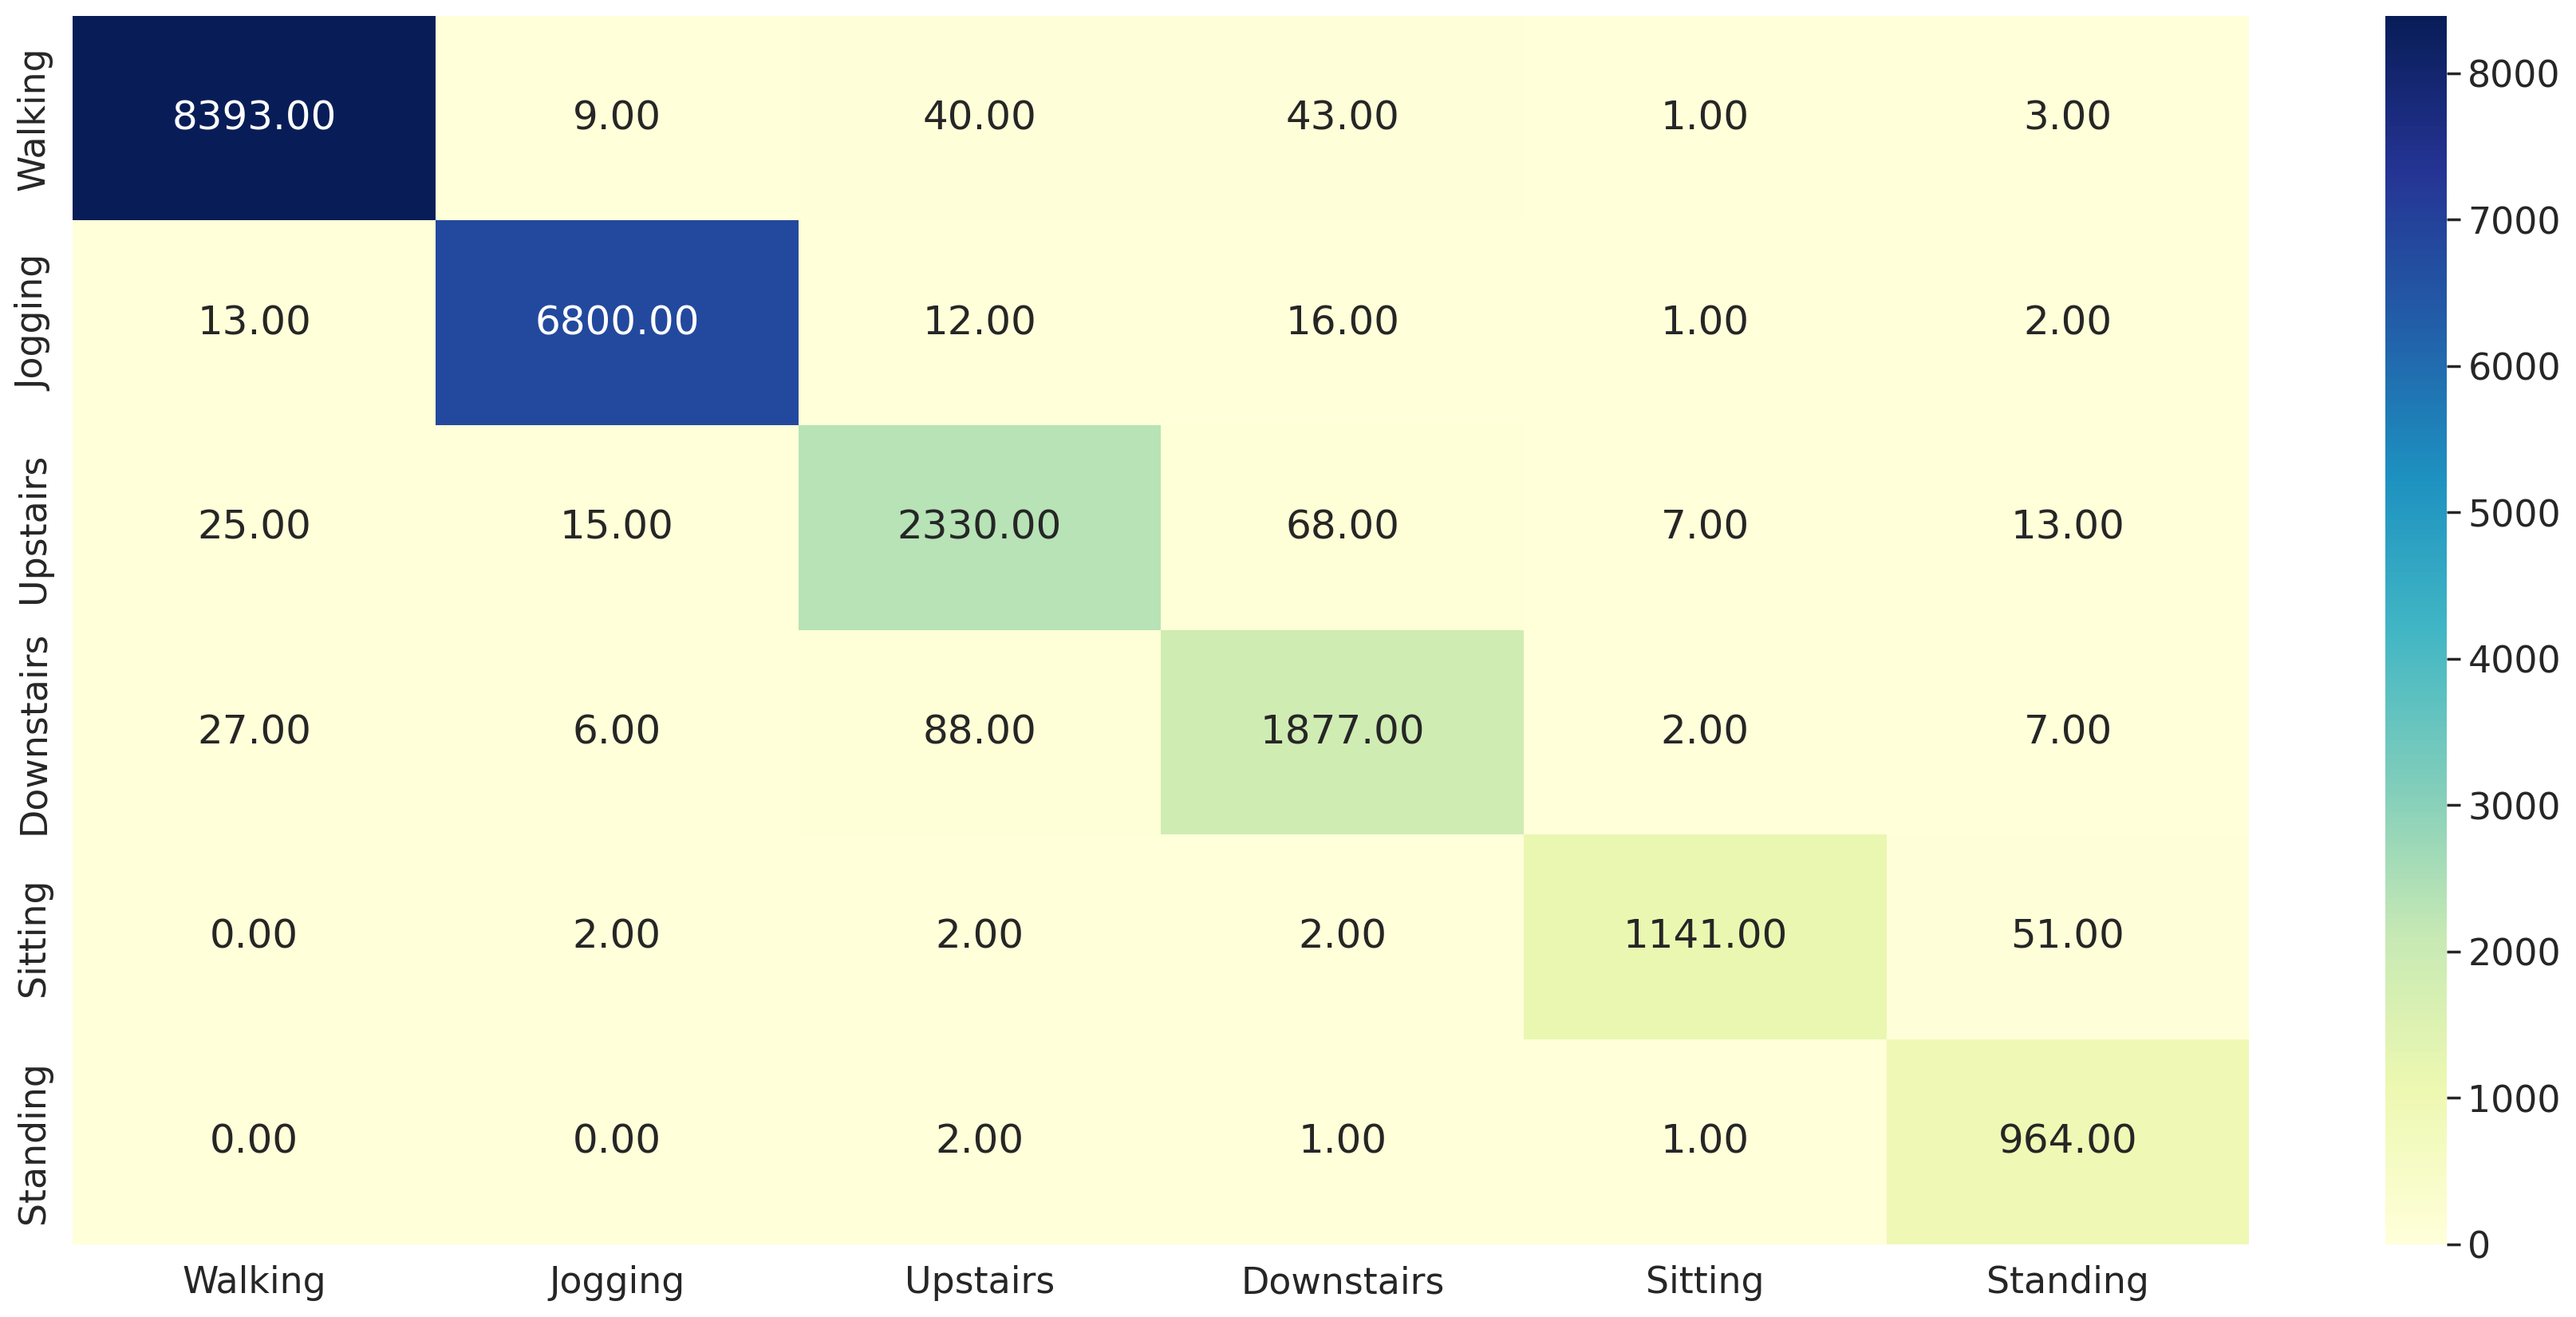

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM4

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 128)           67584     
                                                                 
 dropout_6 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_7 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_8 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 128)              

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 20s 21ms/step - loss: 0.6747 - accuracy: 0.7657 - val_loss: 0.4272 - val_accuracy: 0.8494
Epoch 2/10
550/550 [==============================] - 11s 20ms/step - loss: 0.3360 - accuracy: 0.8836 - val_loss: 0.2315 - val_accuracy: 0.9229
Epoch 3/10
550/550 [==============================] - 11s 19ms/step - loss: 0.2247 - accuracy: 0.9277 - val_loss: 0.2267 - val_accuracy: 0.9300
Epoch 4/10
550/550 [==============================] - 10s 19ms/step - loss: 0.1743 - accuracy: 0.9448 - val_loss: 0.1365 - val_accuracy: 0.9558
Epoch 5/10
550/550 [==============================] - 11s 19ms/step - loss: 0.1378 - accuracy: 0.9554 - val_loss: 0.1372 - val_accuracy: 0.9546
Epoch 6/10
550/550 [==============================] - 10s 19ms/step - loss: 0.1140 - accuracy: 0.9637 - val_loss: 0.1152 - val_accuracy: 0.9639
Epoch 7/10
550/550 [==============================] - 11s 19ms/step - loss: 0.0977 - accuracy: 0.9692 - val_loss: 0.0969 - val_accuracy:

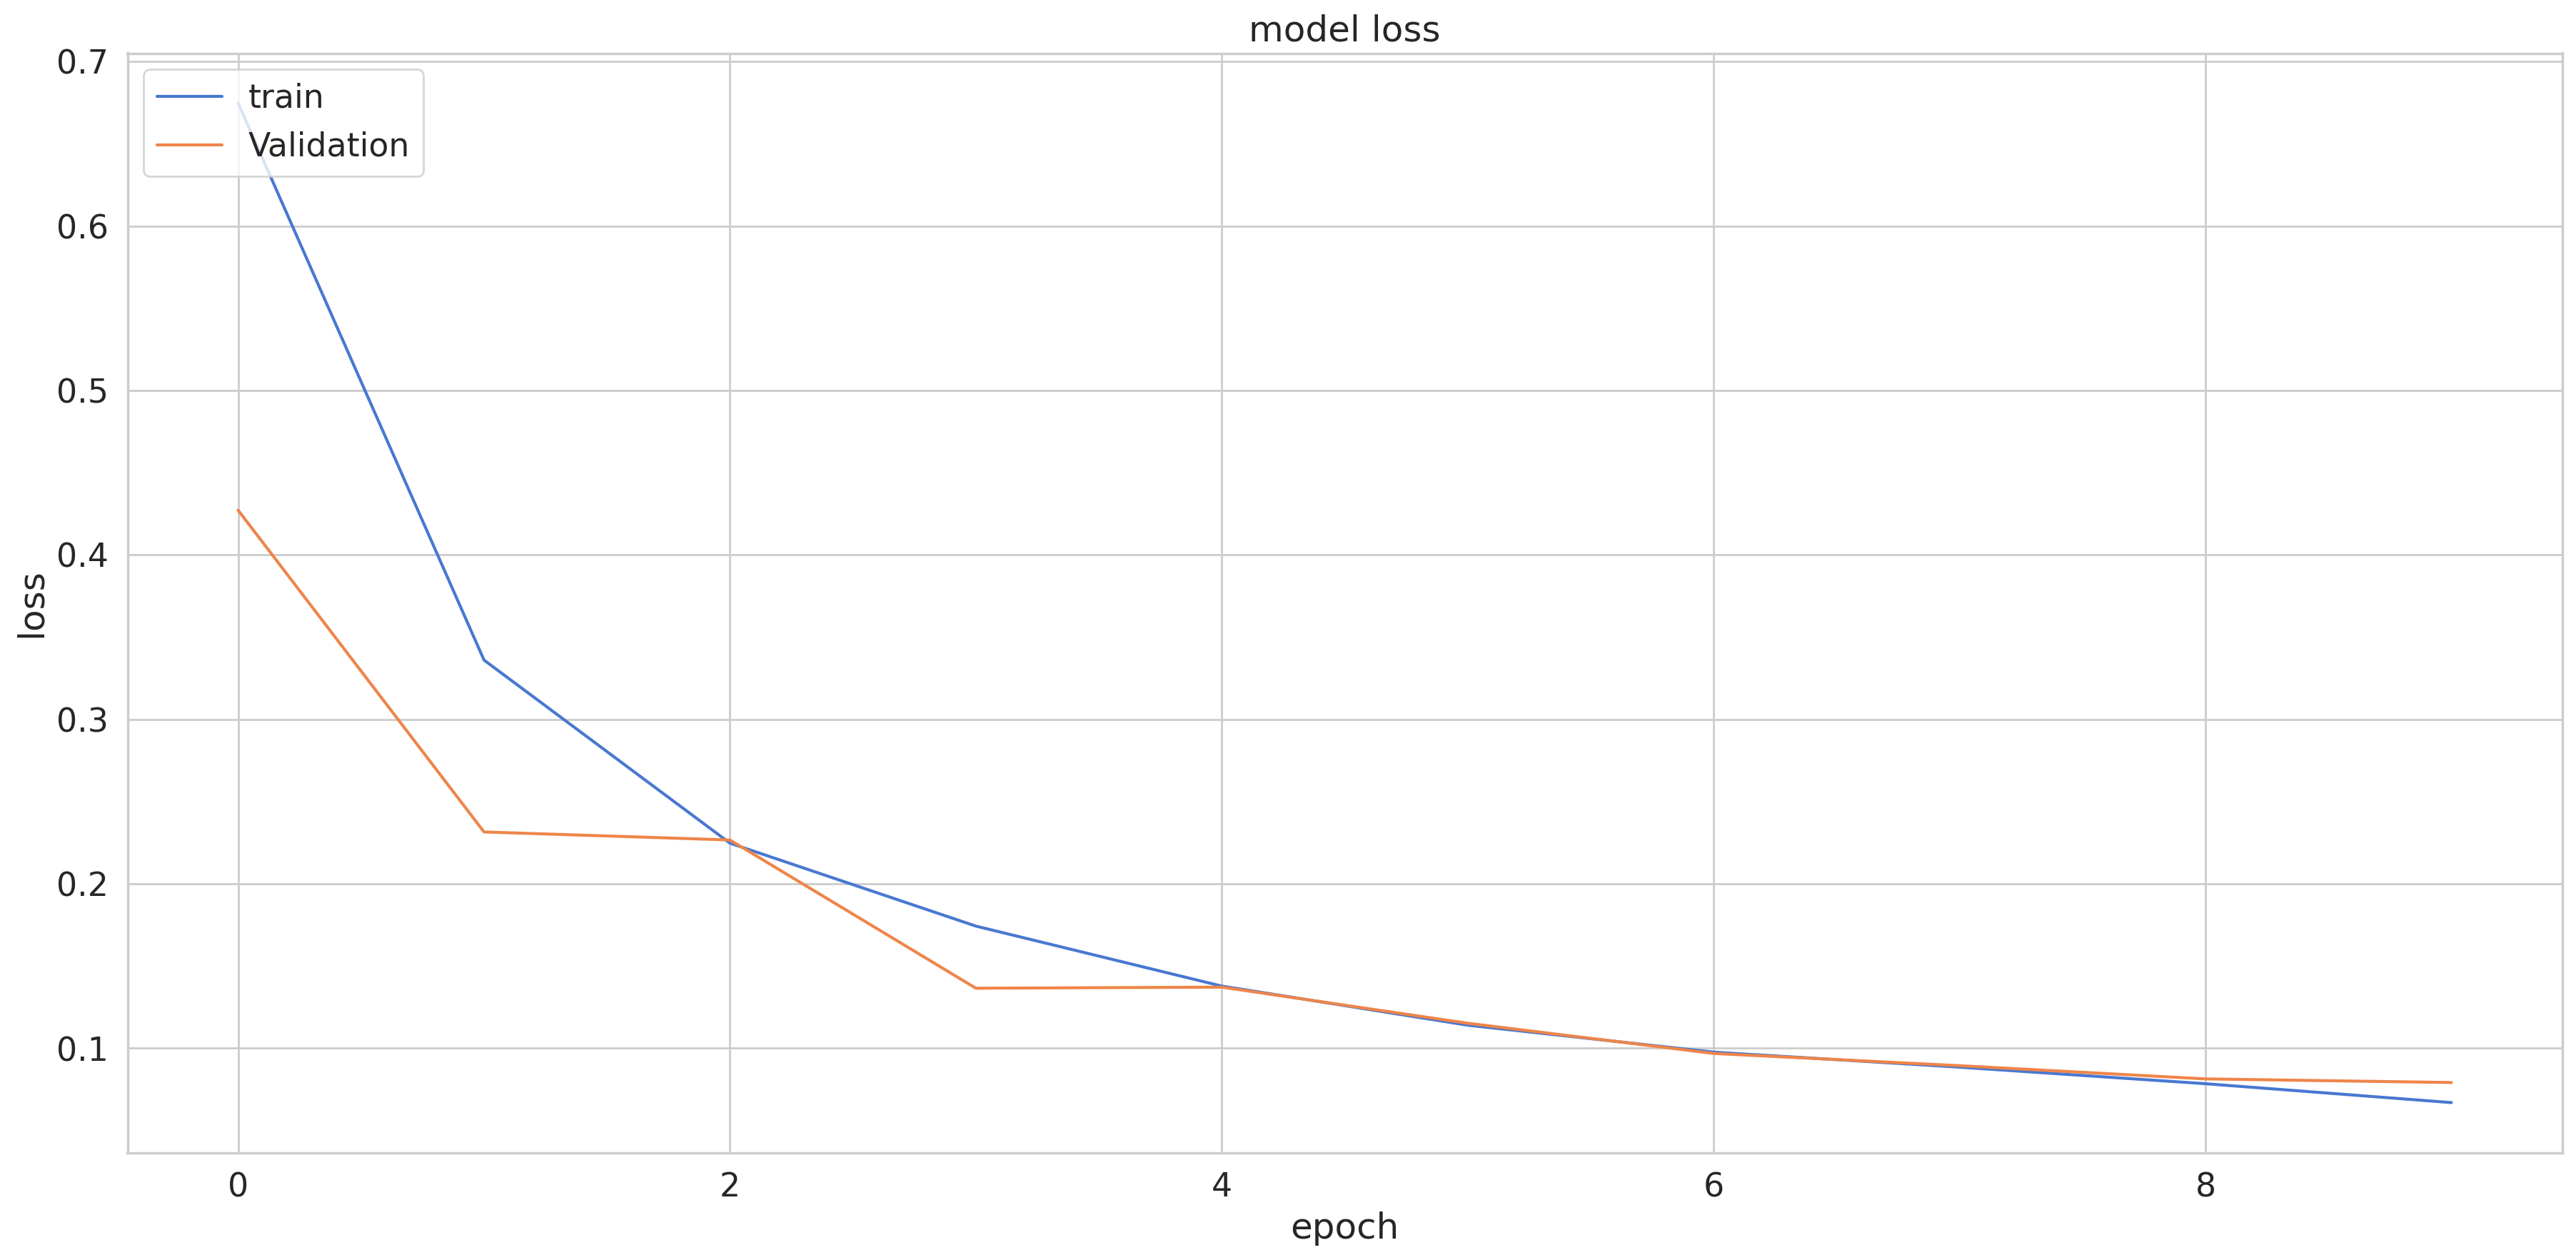

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

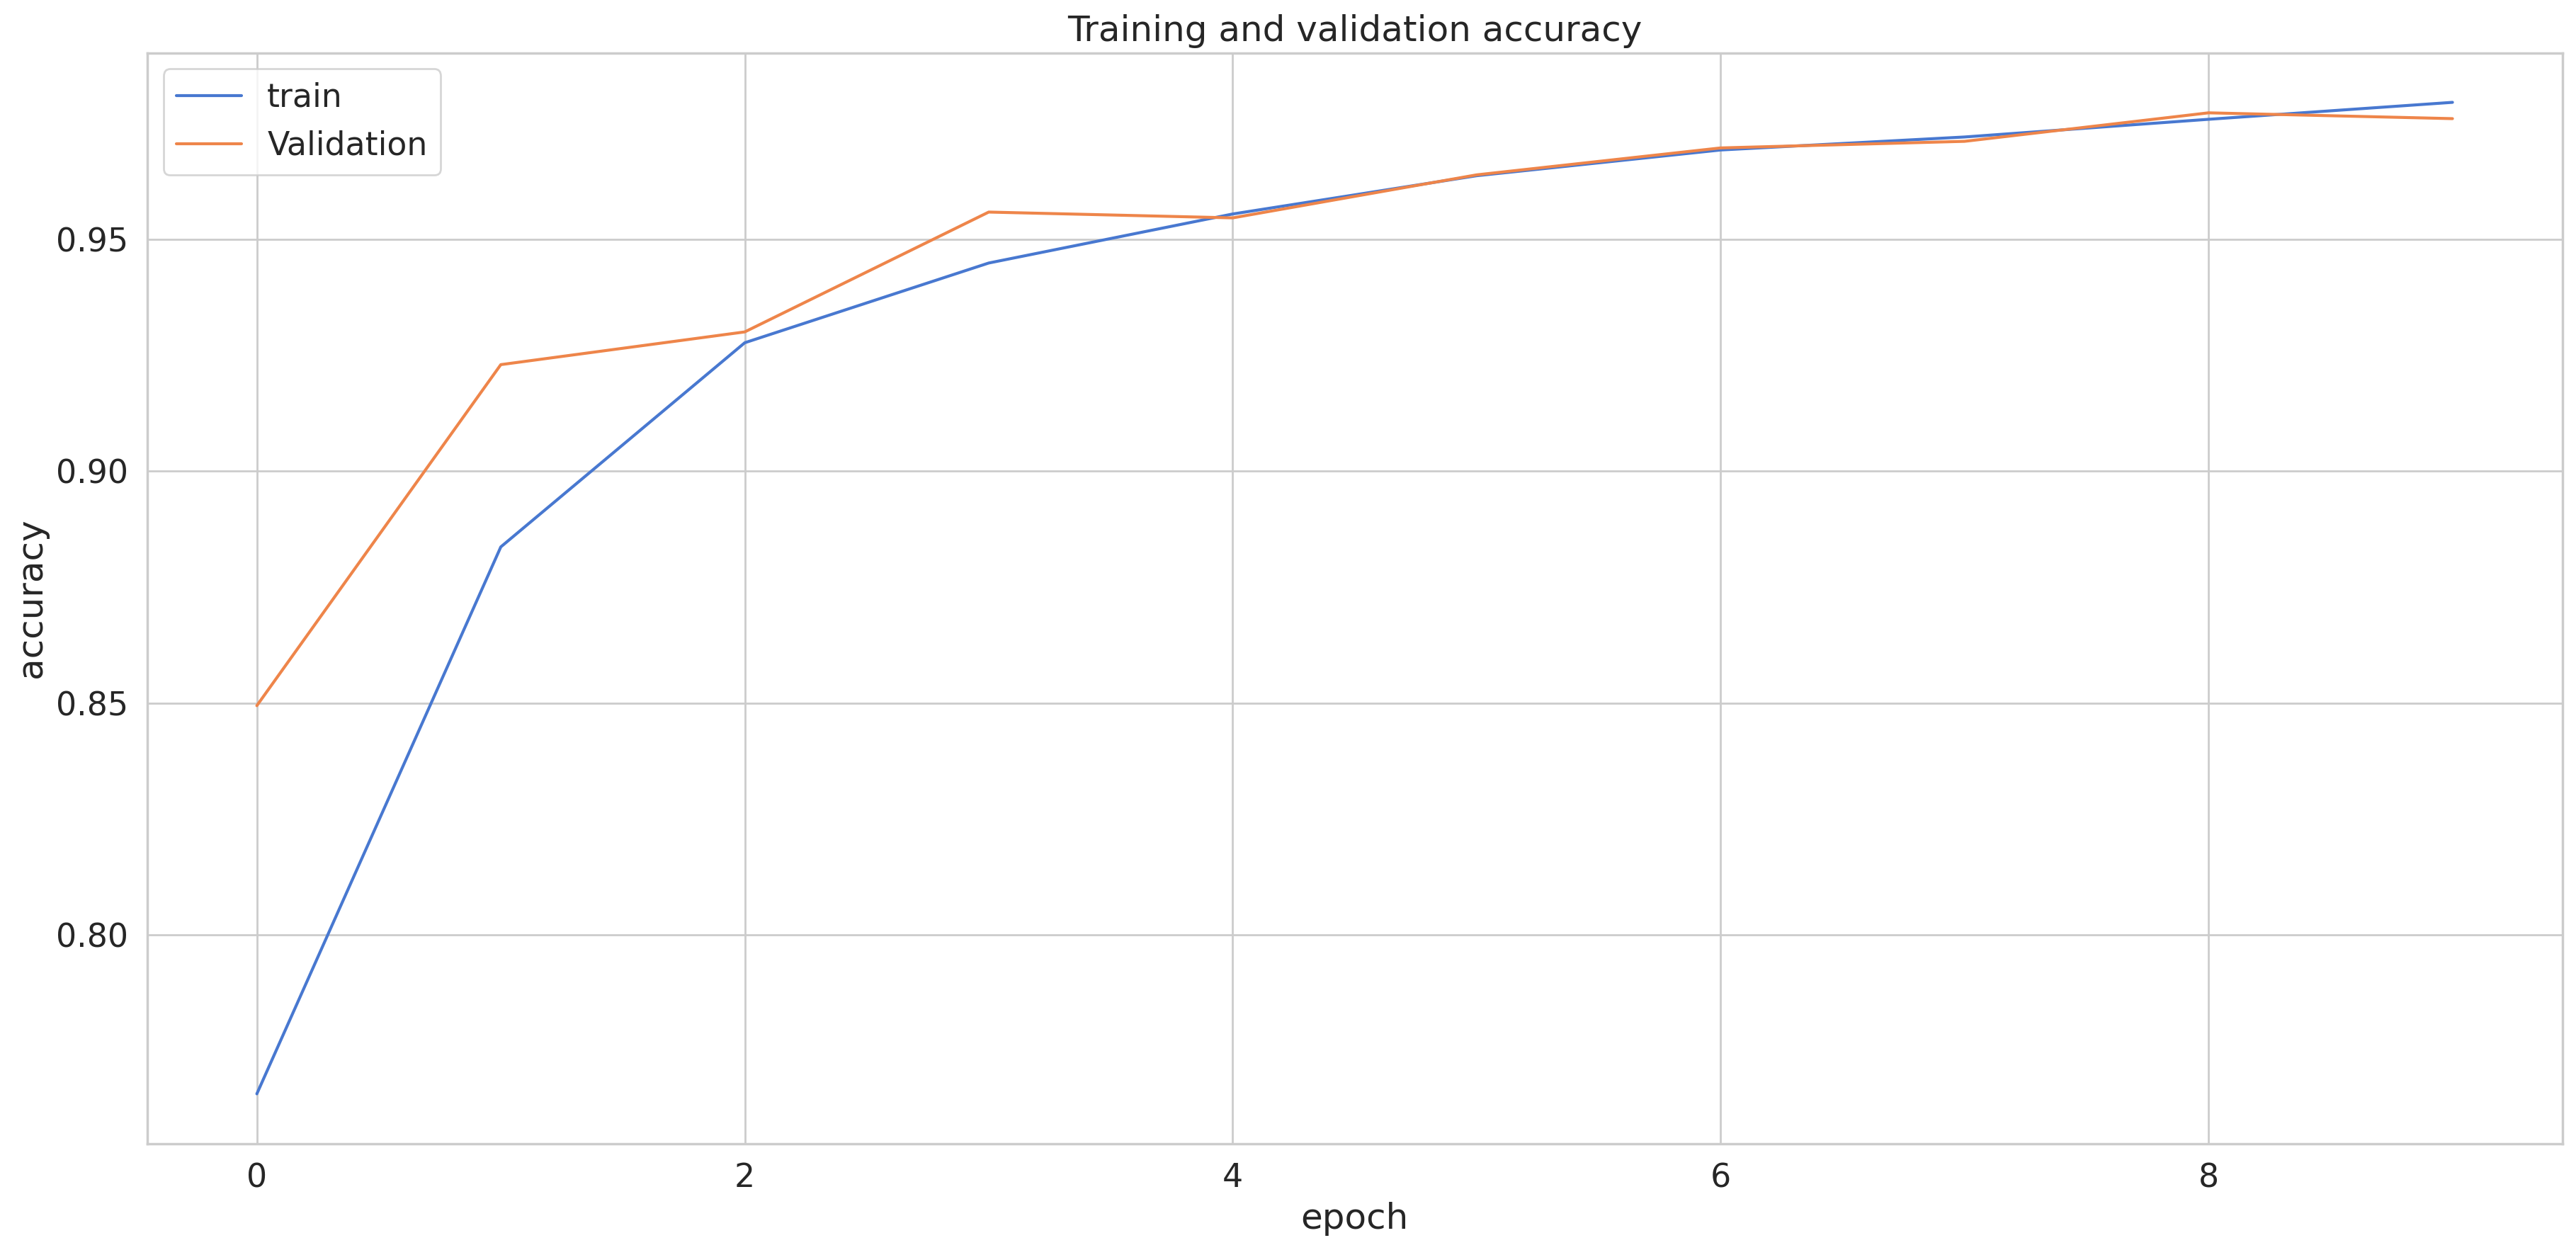

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 5s 5ms/step
f1_score =  0.9754769145657958
0.9756419595702058
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8489
           1       0.99      0.99      0.99      6844
           2       0.93      0.93      0.93      2458
           3       0.95      0.90      0.92      2007
           4       0.97      0.99      0.98      1198
           5       0.98      0.95      0.97       968

    accuracy                           0.98     21964
   macro avg       0.97      0.96      0.96     21964
weighted avg       0.98      0.98      0.98     21964



<Axes: >

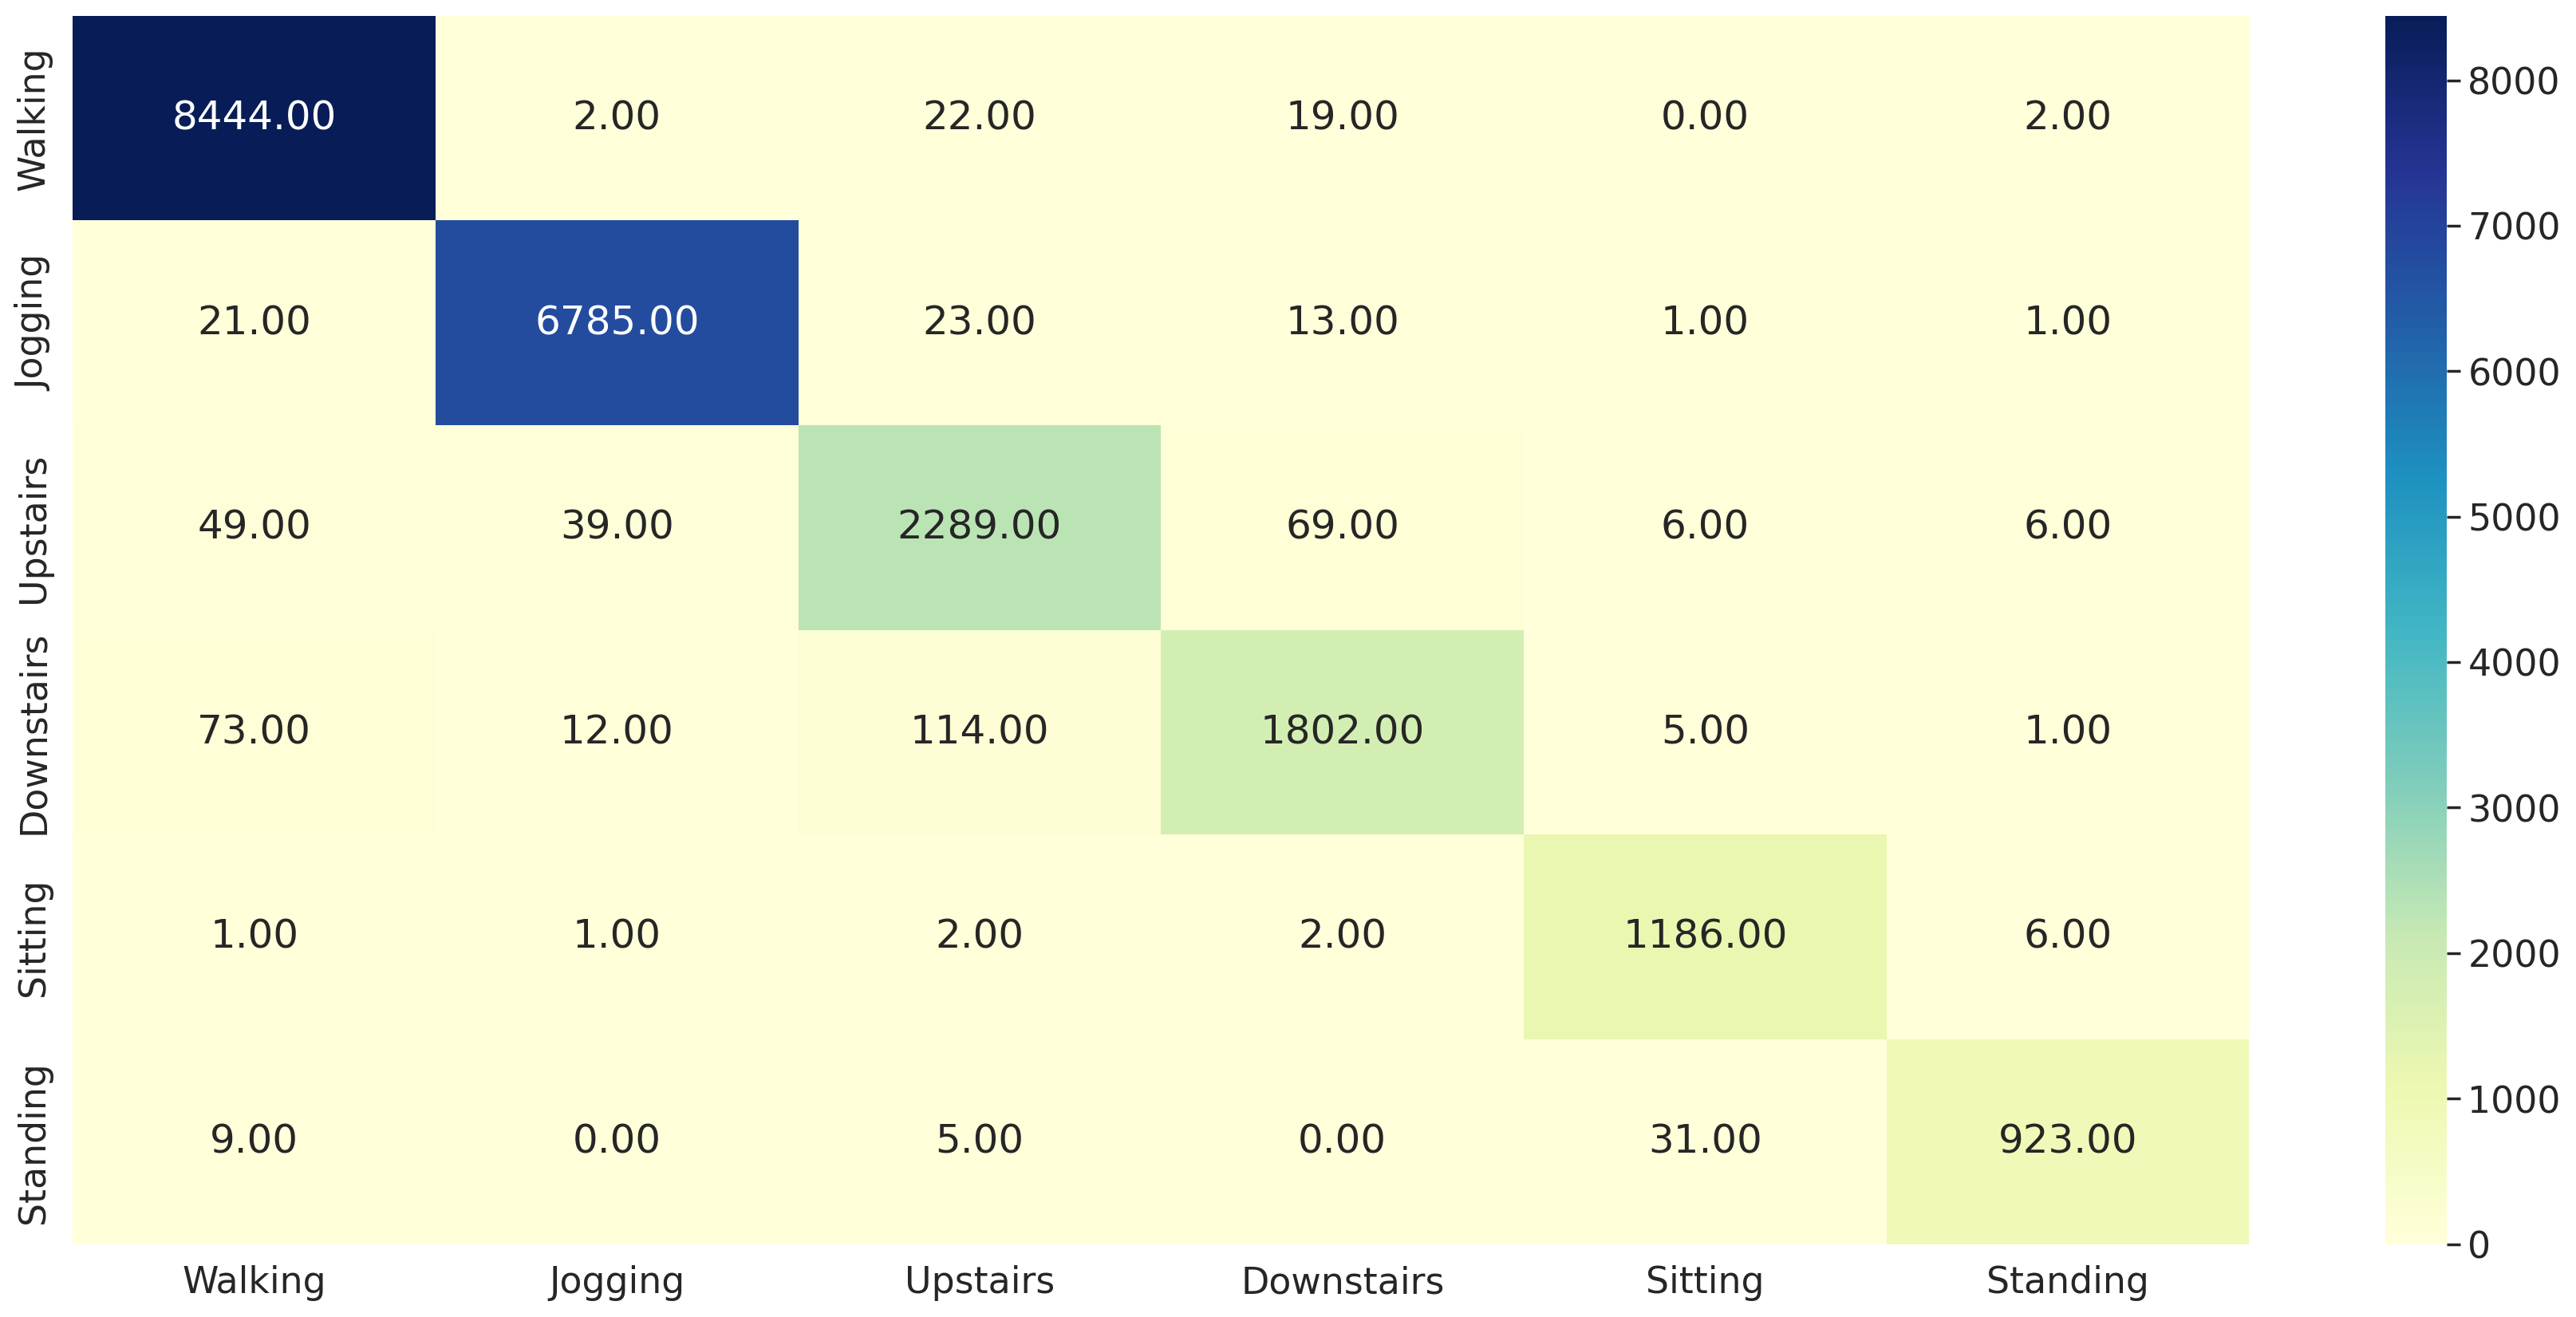

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM5

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))


model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50, 128)           67584     
                                                                 
 dropout_10 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 50, 128)           131584    
                                                                 
 dropout_11 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_12 (LSTM)              (None, 50, 128)           131584    
                                                                 
 dropout_12 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 50, 128)          

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
550/550 [==============================] - 23s 26ms/step - loss: 0.6760 - accuracy: 0.7691 - val_loss: 0.4094 - val_accuracy: 0.8660
Epoch 2/10
550/550 [==============================] - 13s 23ms/step - loss: 0.3111 - accuracy: 0.8994 - val_loss: 0.2609 - val_accuracy: 0.9223
Epoch 3/10
550/550 [==============================] - 13s 23ms/step - loss: 0.2205 - accuracy: 0.9303 - val_loss: 0.1991 - val_accuracy: 0.9363
Epoch 4/10
550/550 [==============================] - 13s 23ms/step - loss: 0.1814 - accuracy: 0.9425 - val_loss: 0.1701 - val_accuracy: 0.9456
Epoch 5/10
550/550 [==============================] - 12s 22ms/step - loss: 0.1423 - accuracy: 0.9552 - val_loss: 0.1453 - val_accuracy: 0.9542
Epoch 6/10
550/550 [==============================] - 13s 23ms/step - loss: 0.1211 - accuracy: 0.9612 - val_loss: 0.1021 - val_accuracy: 0.9660
Epoch 7/10
550/550 [==============================] - 13s 23ms/step - loss: 0.1015 - accuracy: 0.9679 - val_loss: 0.0878 - val_accuracy:

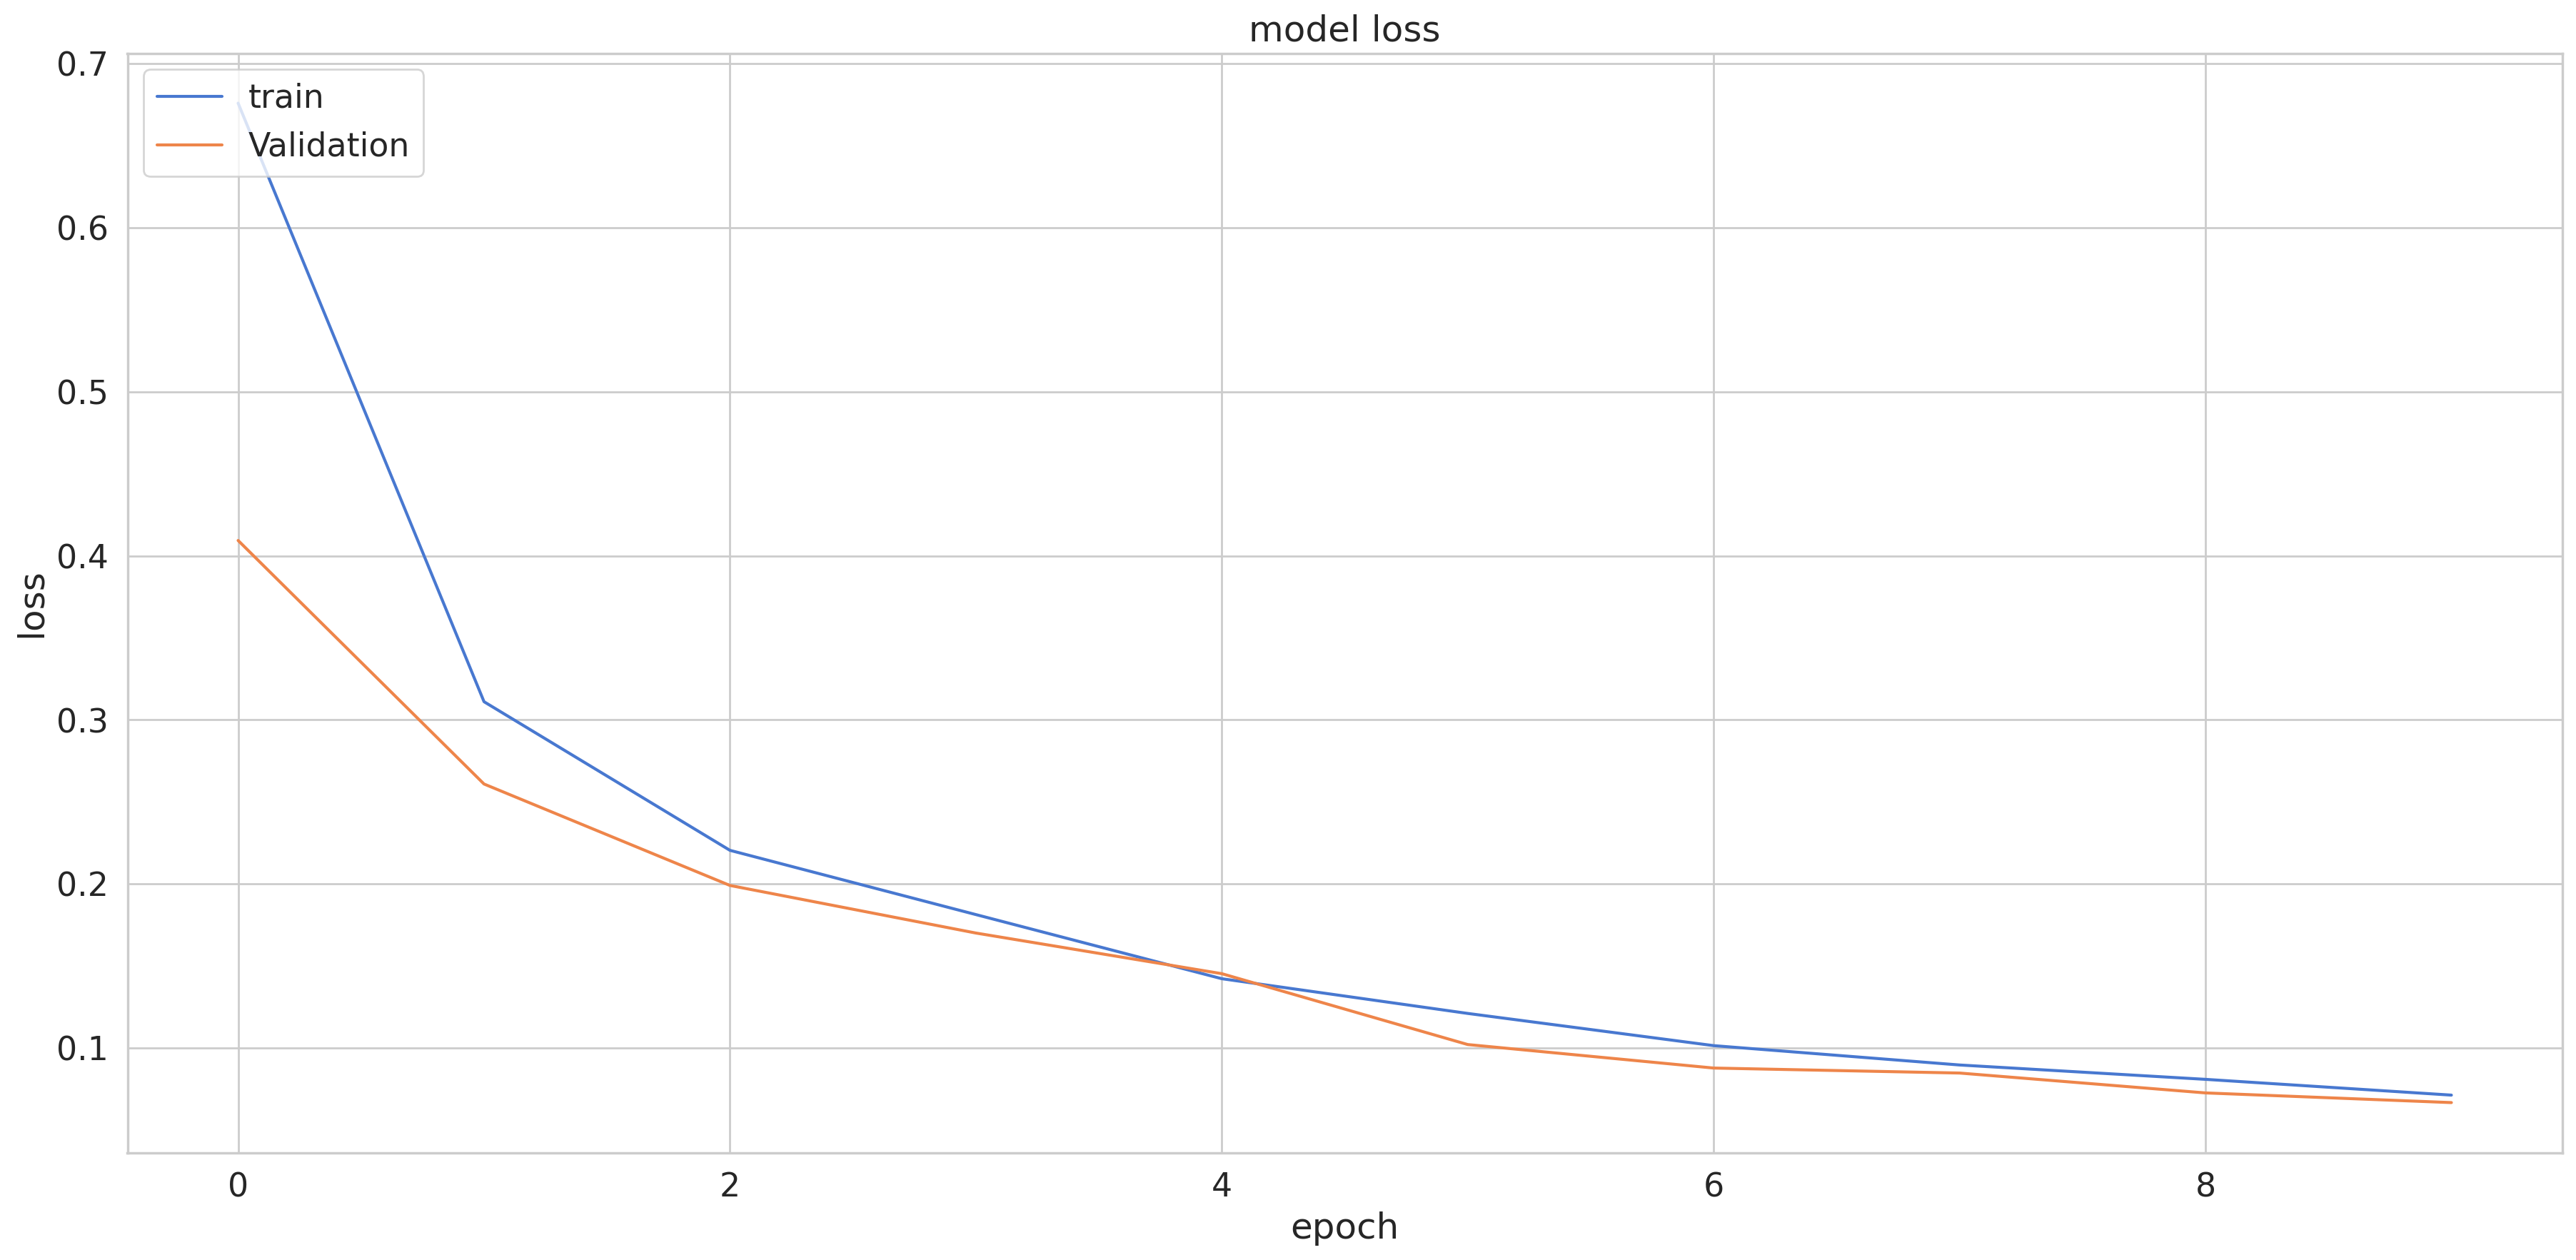

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

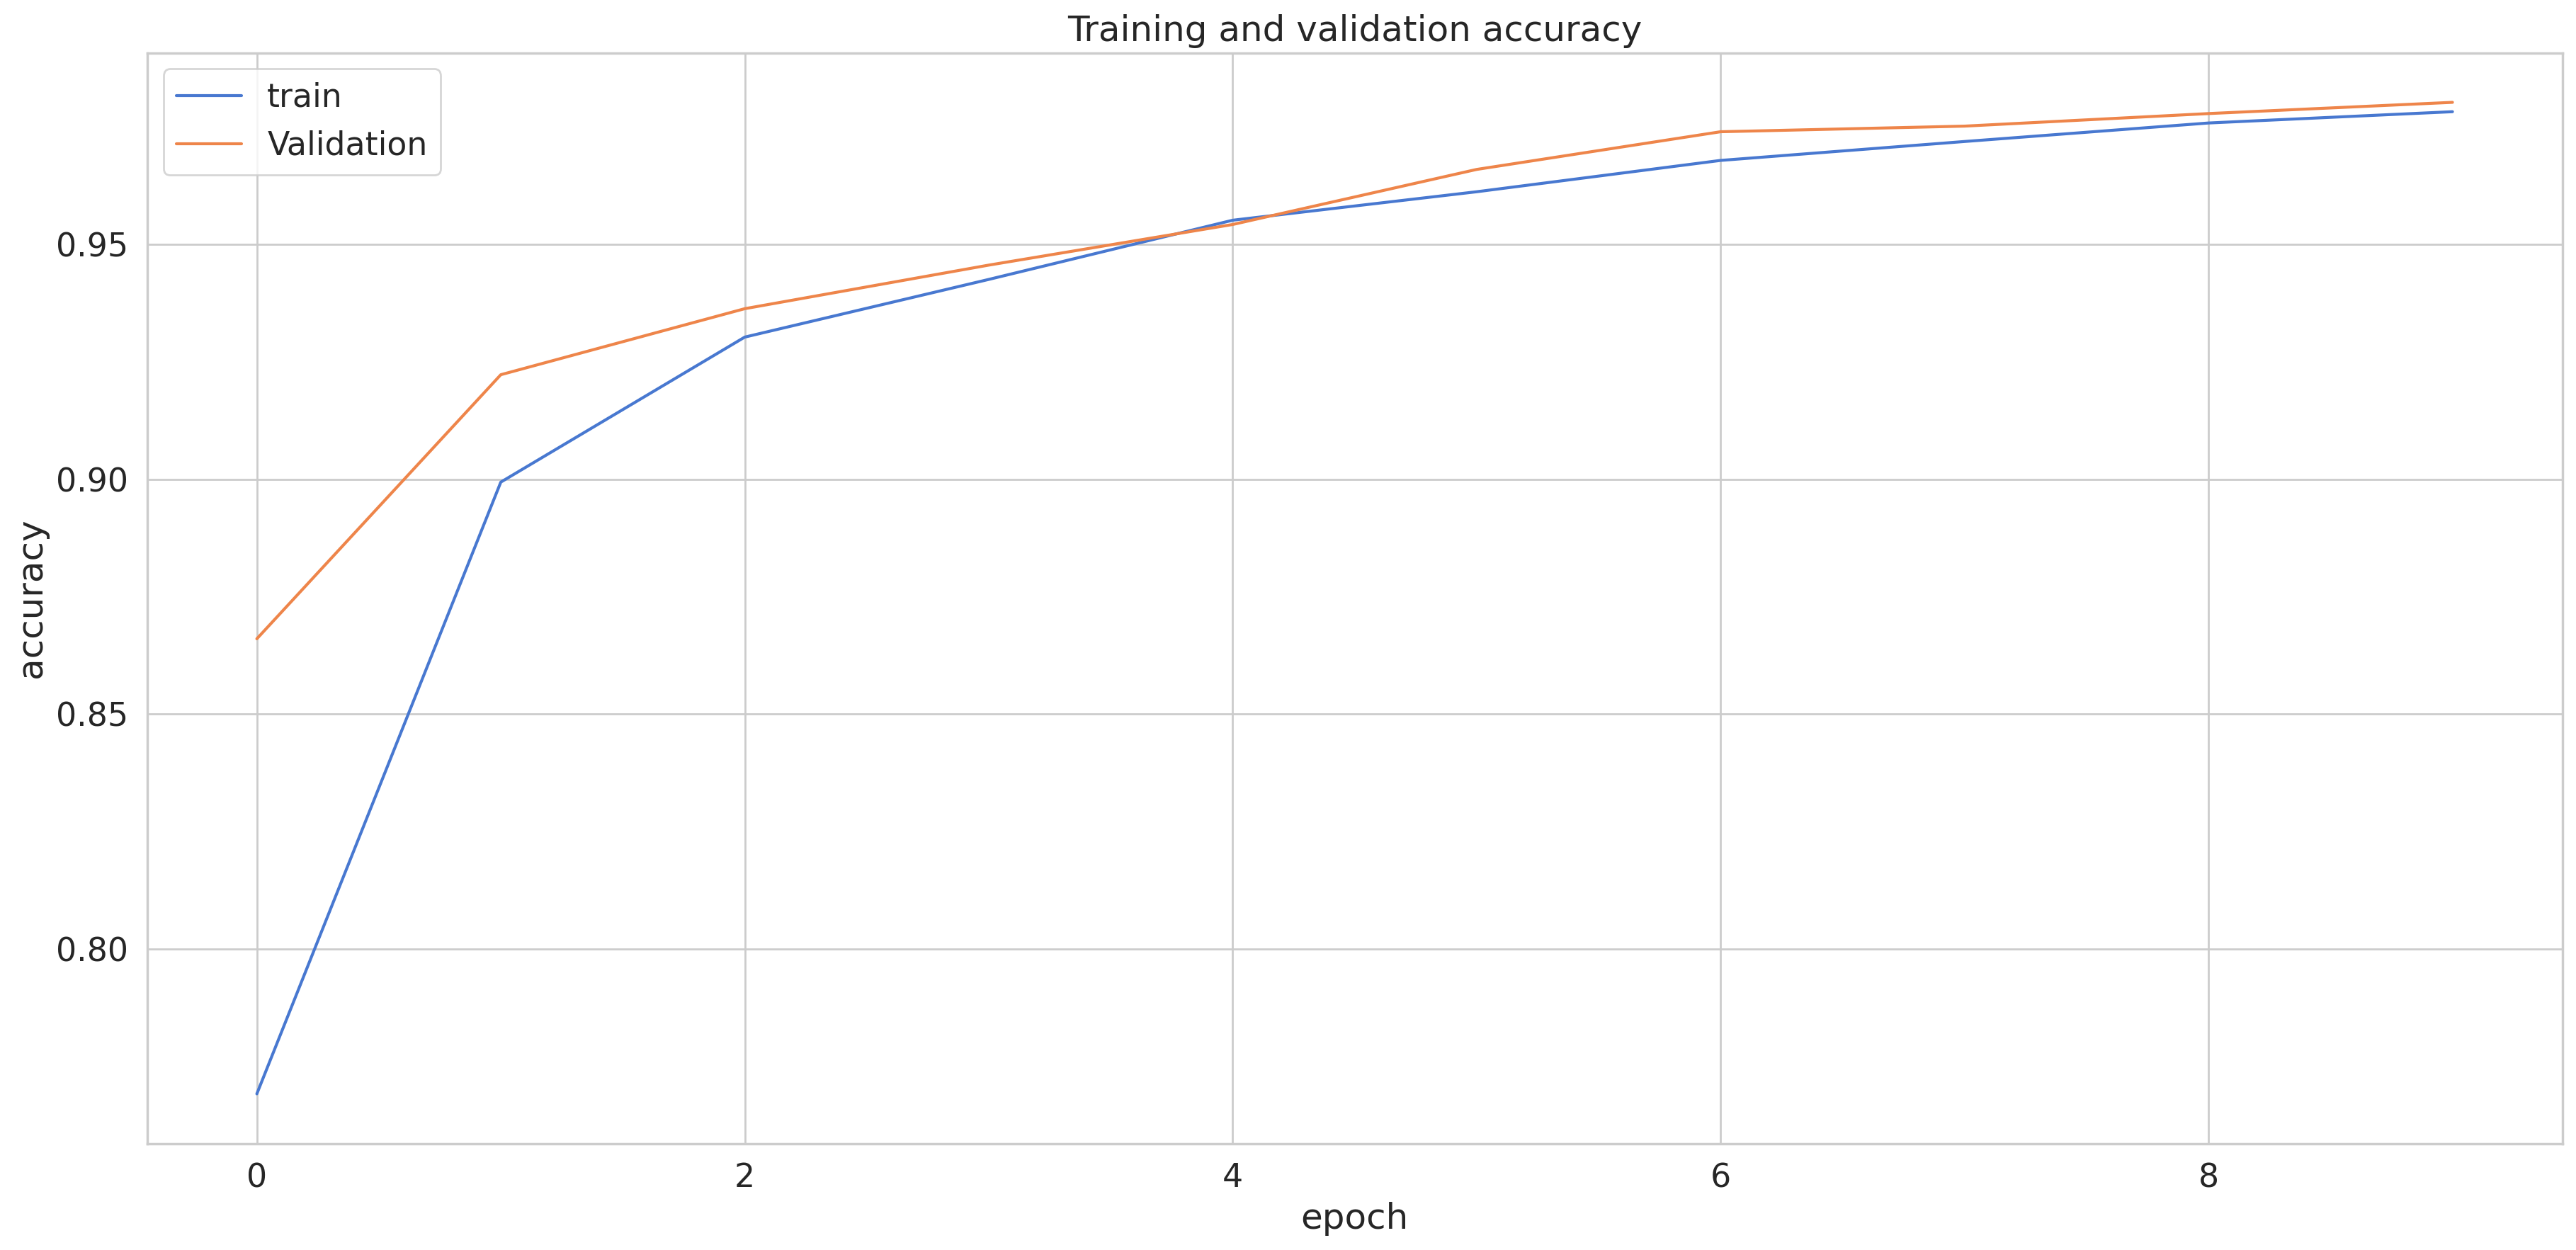

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

687/687 [==============================] - 6s 6ms/step
f1_score =  0.9803958941213726
0.9803769805135677
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8489
           1       1.00      0.99      0.99      6844
           2       0.94      0.95      0.95      2458
           3       0.94      0.94      0.94      2007
           4       0.99      0.95      0.97      1198
           5       0.94      1.00      0.97       968

    accuracy                           0.98     21964
   macro avg       0.97      0.97      0.97     21964
weighted avg       0.98      0.98      0.98     21964



<Axes: >

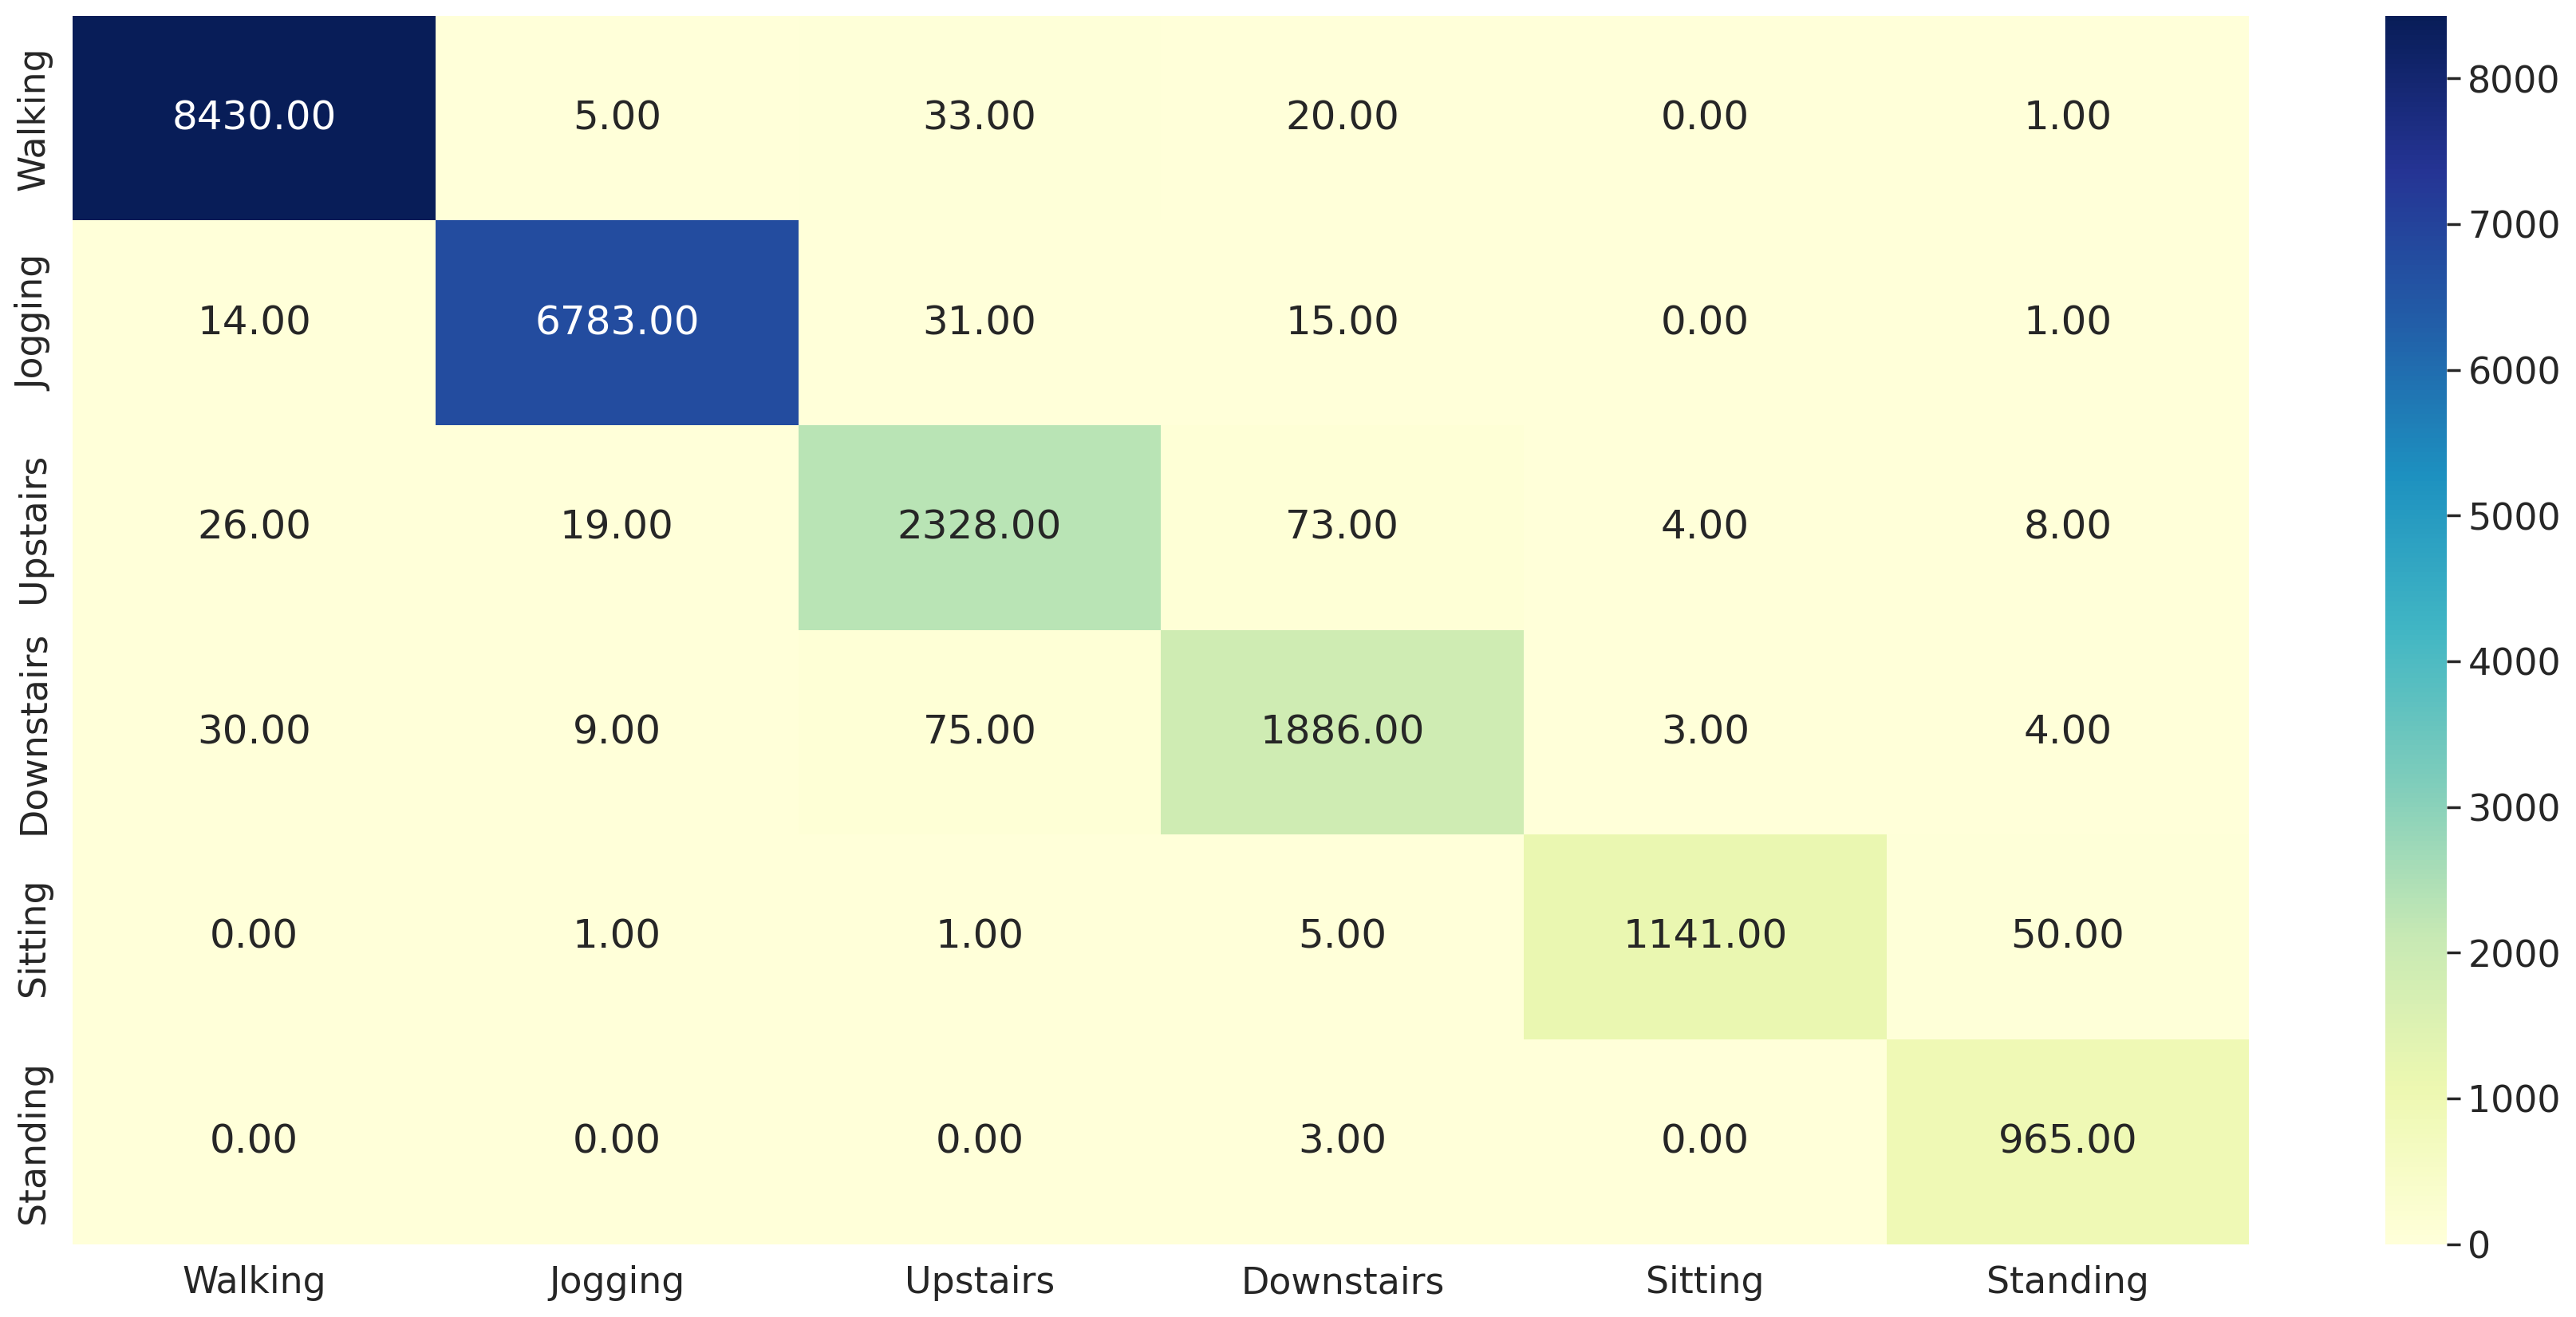

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')